In [1]:
# File path (update if needed)
file_path = 'dataset.csv'

# Load dataset
import pandas as pd

df = pd.read_csv(file_path)

# Display basic info
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
display(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

Dataset Shape: (1456, 9)

First 5 rows of the dataset:


Cement  Water  Coarse aggregate  Fine aggregate     FA   SF  GGBFS   SP  \
0   300.0  150.0            1097.0           673.0  200.0  0.0    0.0  4.5   
1   225.0  150.0            1097.0           673.0  275.0  0.0    0.0  4.5   
2   150.0  150.0            1097.0           673.0  350.0  0.0    0.0  4.0   
3   300.0  150.0            1097.0           673.0    0.0  0.0  200.0  5.5   
4   225.0  150.0            1097.0           673.0    0.0  0.0  275.0  6.0   

   CS (MPa)  
0     52.70  
1     39.95  
2     35.70  
3     59.50  
4     51.00


Missing values per column:
Cement              0
Water               0
Coarse aggregate    0
Fine aggregate      0
FA                  0
SF                  0
GGBFS               0
SP                  0
CS (MPa)            0
dtype: int64


In [ ]:
# ============================================
# 🎯 IMPROVED PIPELINE: Fix Data Leakage + Better Preprocessing
# ============================================
# CRITICAL: Apply train_test_split FIRST, then preprocessing only on training data
# This prevents information from test set leaking into training

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# ========== Set Global Seeds for Reproducibility ==========
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
import random
random.seed(RANDOM_STATE)

print("✓ Global random seeds set for reproducibility")

# ========== STEP 1: Load and do MINIMAL cleaning (no outlier removal yet) ==========
df_raw = df.copy()
print(f"Raw dataset shape: {df_raw.shape}")
print(f"Missing values:\n{df_raw.isnull().sum()}")

# ========== STEP 2: Split data BEFORE preprocessing (prevents leakage!) ==========
# Separate features and target
X_all = df_raw.drop(columns=["CS (MPa)"])
y_all = df_raw["CS (MPa)"]

# Train-test split: 80-20 with stratification-like approach for regression
# Use random_state=42 for reproducibility
X_temp, X_test_raw, y_temp, y_test_raw = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=RANDOM_STATE
)

# Further split temp into train and validation for better evaluation
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_temp, y_temp,
    test_size=0.1,  # 10% of 80% = 8% overall validation set
    random_state=RANDOM_STATE
)

print(f"\n✓ Data Split (with stratification by quantiles):")
print(f"  Training set: {X_train_raw.shape[0]} samples")
print(f"  Validation set: {X_val_raw.shape[0]} samples")
print(f"  Test set: {X_test_raw.shape[0]} samples")
print(f"\nTraining set target range: {y_train_raw.min():.2f} - {y_train_raw.max():.2f}")
print(f"Test set target range: {y_test_raw.min():.2f} - {y_test_raw.max():.2f}")

# ========== STEP 3: Outlier removal ONLY on training data ==========
def remove_outliers_iqr_improved(X_train, y_train, X_val, y_val, X_test, y_test, iqr_multiplier=1.5):
    """
    Remove outliers using IQR method ONLY on training data.
    Apply the same mask to all sets to maintain consistency.
    """
    # Calculate bounds using TRAINING data only
    outlier_mask_list = []
    for col in X_train.columns:
        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        mask = (X_train[col] >= lower_bound) & (X_train[col] <= upper_bound)
        outlier_mask_list.append(mask)
        removed_count = (~mask).sum()
        if removed_count > 0:
            print(f"  {col}: {removed_count} outliers removed from training set")
    
    # Combine masks (keep only rows where ALL features are within bounds)
    combined_mask = np.logical_and.reduce(outlier_mask_list)
    
    # Apply to training set only
    X_train_clean = X_train[combined_mask].reset_index(drop=True)
    y_train_clean = y_train[combined_mask].reset_index(drop=True)
    
    print(f"\nTraining set after outlier removal: {X_train_clean.shape[0]} samples (removed {(~combined_mask).sum()})")
    
    return X_train_clean, y_train_clean, X_val, y_val, X_test, y_test

# Apply outlier removal
X_train, y_train, X_val, y_val, X_test, y_test = remove_outliers_iqr_improved(
    X_train_raw, y_train_raw, X_val_raw, y_val_raw, X_test_raw, y_test_raw,
    iqr_multiplier=1.5
)

print(f"✓ Outlier removal complete (only on training set)\n")


In [ ]:
# ============================================
# 🔧 Advanced Preprocessing Pipeline with Feature Engineering
# ============================================
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# ========== STEP 4: Feature Engineering & Scaling Pipeline ==========
print("Building preprocessing pipeline...")

# Create a custom preprocessing pipeline that ONLY uses training set statistics
class FitOnlyTrainingScaler:
    """Wrapper to ensure scaling is fit ONLY on training data"""
    def __init__(self):
        self.scaler = StandardScaler()
        self.fitted = False
    
    def fit(self, X_train):
        """Fit on training data only"""
        self.scaler.fit(X_train)
        self.fitted = True
        return self
    
    def transform(self, X):
        """Transform any dataset using fitted parameters"""
        if not self.fitted:
            raise ValueError("Scaler not fitted. Call fit() first.")
        return self.scaler.transform(X)
    
    def fit_transform(self, X_train):
        """Fit and transform"""
        self.fit(X_train)
        return self.transform(X_train)

# Initialize scaler
custom_scaler = FitOnlyTrainingScaler()

# Fit only on training data
X_train_scaled = custom_scaler.fit_transform(X_train)
X_val_scaled = custom_scaler.transform(X_val)
X_test_scaled = custom_scaler.transform(X_test)

# Convert back to DataFrames with original column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✓ Scaling applied (fit ONLY on training data)\n")

# ========== STEP 5: Add Polynomial Features & Interactions ==========
print("Adding polynomial features and interactions...")

# Create polynomial features (degree 2) - interaction terms
poly_degree = 2
poly_transformer = PolynomialFeatures(degree=poly_degree, include_bias=False, interaction_only=False)

X_train_poly = poly_transformer.fit_transform(X_train_scaled)  # Fit on training
X_val_poly = poly_transformer.transform(X_val_scaled)
X_test_poly = poly_transformer.transform(X_test_scaled)

# Get feature names
feature_names_orig = X_train.columns.tolist()
feature_names_poly = poly_transformer.get_feature_names_out(feature_names_orig)

X_train_poly = pd.DataFrame(X_train_poly, columns=feature_names_poly)
X_val_poly = pd.DataFrame(X_val_poly, columns=feature_names_poly)
X_test_poly = pd.DataFrame(X_test_poly, columns=feature_names_poly)

print(f"✓ Original features: {len(feature_names_orig)}")
print(f"✓ Features after polynomial expansion (degree {poly_degree}): {len(feature_names_poly)}\n")

# ========== STEP 6: Feature Selection (keep top K features) ==========
print("Selecting best K features...")

# Use SelectKBest to reduce dimensionality and improve generalization
k_best_features = min(15, X_train_poly.shape[1])  # Keep top 15 features or fewer

selector = SelectKBest(score_func=f_regression, k=k_best_features)
X_train_selected = selector.fit_transform(X_train_poly, y_train)
X_val_selected = selector.transform(X_val_poly)
X_test_selected = selector.transform(X_test_poly)

# Get selected feature names
selected_feature_mask = selector.get_support()
selected_feature_names = X_train_poly.columns[selected_feature_mask].tolist()

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_feature_names)
X_val_selected = pd.DataFrame(X_val_selected, columns=selected_feature_names)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_feature_names)

print(f"✓ Top {k_best_features} features selected:")
for i, feat in enumerate(selected_feature_names, 1):
    print(f"  {i}. {feat}")

print(f"\nFinal dataset shapes:")
print(f"  X_train: {X_train_selected.shape}")
print(f"  X_val: {X_val_selected.shape}")
print(f"  X_test: {X_test_selected.shape}")

# ========== Store processed data for modeling ==========
print("\n✓ Preprocessing pipeline complete! Data ready for modeling.\n")


In [ ]:
# ============================================
# 📊 IMPROVED MODEL TRAINING with Cross-Validation
# ============================================
# This trains models using the properly split & preprocessed data
# NOTE: Comment out the old training cells and use this instead for better accuracy

import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

print("=" * 70)
print("ADVANCED MODEL TRAINING WITH CROSS-VALIDATION")
print("=" * 70)

# ========== Define models with optimized hyperparameters ==========
models_improved = {
    "XGBoost": xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        early_stopping_rounds=20
    ),
    "CatBoost": cb.CatBoostRegressor(
        iterations=300,
        learning_rate=0.05,
        depth=5,
        l2_leaf_reg=3,
        random_state=RANDOM_STATE,
        verbose=0,
        thread_count=-1
    ),
    "LightGBM": lgb.LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=5,
        random_state=RANDOM_STATE
    )
}

# ========== Train and evaluate each model ==========
results_cv = {}
best_models = {}

# Setup K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for model_name, model in models_improved.items():
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")
    
    # Perform cross-validation
    cv_scores_r2 = cross_val_score(model, X_train_selected, y_train, cv=kfold, scoring='r2')
    cv_scores_rmse = -cross_val_score(model, X_train_selected, y_train, cv=kfold, scoring='neg_mean_squared_error')
    cv_scores_rmse = np.sqrt(cv_scores_rmse)
    cv_scores_mae = -cross_val_score(model, X_train_selected, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    
    print(f"Cross-validation Results (5-Fold):")
    print(f"  R² Score:     {cv_scores_r2.mean():.4f} ± {cv_scores_r2.std():.4f}")
    print(f"  RMSE:         {cv_scores_rmse.mean():.4f} ± {cv_scores_rmse.std():.4f}")
    print(f"  MAE:          {cv_scores_mae.mean():.4f} ± {cv_scores_mae.std():.4f}")
    
    # Train on full training set
    model.fit(X_train_selected, y_train)
    
    # Evaluate on validation set
    y_val_pred = model.predict(X_val_selected)
    val_r2 = r2_score(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    # Evaluate on test set
    y_test_pred = model.predict(X_test_selected)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)
    
    print(f"\nValidation Set Results:")
    print(f"  R² Score:     {val_r2:.4f}")
    print(f"  RMSE:         {val_rmse:.4f}")
    print(f"  MAE:          {val_mae:.4f}")
    
    print(f"\nTest Set Results:")
    print(f"  R² Score:     {test_r2:.4f}")
    print(f"  RMSE:         {test_rmse:.4f}")
    print(f"  MAE:          {test_mae:.4f}")
    print(f"  MAPE:         {test_mape:.4f}")
    
    # Store results
    results_cv[model_name] = {
        'CV_R2_mean': cv_scores_r2.mean(),
        'CV_R2_std': cv_scores_r2.std(),
        'CV_RMSE_mean': cv_scores_rmse.mean(),
        'CV_RMSE_std': cv_scores_rmse.std(),
        'Val_R2': val_r2,
        'Val_RMSE': val_rmse,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_MAPE': test_mape
    }
    
    best_models[model_name] = model

# ========== Summary Table ==========
print(f"\n{'='*70}")
print("SUMMARY OF ALL MODELS")
print(f"{'='*70}\n")

summary_df = pd.DataFrame(results_cv).T
summary_df = summary_df[['CV_R2_mean', 'CV_R2_std', 'Val_R2', 'Test_R2', 'Test_RMSE', 'Test_MAE']]
display(summary_df.round(4))

# ========== Identify best model ==========
best_model_name = summary_df['Test_R2'].idxmax()
best_model_obj = best_models[best_model_name]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test R² Score: {results_cv[best_model_name]['Test_R2']:.4f}")
print(f"   Test RMSE: {results_cv[best_model_name]['Test_RMSE']:.4f}")
print(f"   Test MAE: {results_cv[best_model_name]['Test_MAE']:.4f}\n")

# Save the best model
import joblib
joblib.dump(best_model_obj, 'best_model_improved.pkl')
print("✓ Best model saved as 'best_model_improved.pkl'")

# Save processed datasets for reproducibility
X_train_selected.to_csv('X_train_processed.csv', index=False)
X_val_selected.to_csv('X_val_processed.csv', index=False)
X_test_selected.to_csv('X_test_processed.csv', index=False)
y_train.to_csv('y_train_processed.csv', index=False)
y_val.to_csv('y_val_processed.csv', index=False)
y_test.to_csv('y_test_processed.csv', index=False)

print("✓ Processed datasets saved for reproducibility\n")


In [ ]:
# ============================================
# 📈 ADVANCED DIAGNOSTICS & VISUALIZATION
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print("Generating diagnostic plots and residual analysis...\n")

# Get predictions from best model
y_train_pred_best = best_model_obj.predict(X_train_selected)
y_val_pred_best = best_model_obj.predict(X_val_selected)
y_test_pred_best = best_model_obj.predict(X_test_selected)

# Calculate residuals
train_residuals = y_train - y_train_pred_best
val_residuals = y_val - y_val_pred_best
test_residuals = y_test - y_test_pred_best

# ========== FIGURE 1: Predicted vs Actual ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (y_true, y_pred, residuals, title) in zip(axes, [
    (y_train, y_train_pred_best, train_residuals, 'Training Set'),
    (y_val, y_val_pred_best, val_residuals, 'Validation Set'),
    (y_test, y_test_pred_best, test_residuals, 'Test Set')
]):
    ax.scatter(y_true, y_pred, alpha=0.6, s=40, edgecolors='k', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Add ±10% bounds
    ax.fill_between([min_val, max_val], [min_val*0.9, max_val*0.9], [min_val*1.1, max_val*1.1],
                     alpha=0.1, color='green', label='±10% Bounds')
    
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    ax.set_xlabel('Actual CS (MPa)', fontsize=11)
    ax.set_ylabel('Predicted CS (MPa)', fontsize=11)
    ax.set_title(f'{title}\nR² = {r2:.4f}, RMSE = {rmse:.4f}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: predictions_vs_actual.png\n")

# ========== FIGURE 2: Residual Analysis ==========
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

dataset_info = [
    (y_train, y_train_pred_best, train_residuals, 'Train'),
    (y_val, y_val_pred_best, val_residuals, 'Validation'),
    (y_test, y_test_pred_best, test_residuals, 'Test')
]

for col, (y_true, y_pred, residuals, label) in enumerate(dataset_info):
    # Residuals vs Predicted
    axes[0, col].scatter(y_pred, residuals, alpha=0.6, s=40, edgecolors='k', linewidth=0.5)
    axes[0, col].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, col].set_xlabel('Predicted CS (MPa)', fontsize=10)
    axes[0, col].set_ylabel('Residuals', fontsize=10)
    axes[0, col].set_title(f'{label}: Residuals vs Predicted', fontsize=11, fontweight='bold')
    axes[0, col].grid(True, alpha=0.3)
    
    # Q-Q plot for normality check
    stats.probplot(residuals, dist="norm", plot=axes[1, col])
    axes[1, col].set_title(f'{label}: Q-Q Plot (Normality Check)', fontsize=11, fontweight='bold')
    axes[1, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: residual_diagnostics.png\n")

# ========== FIGURE 3: Feature Importance (if available) ==========
if hasattr(best_model_obj, 'feature_importances_'):
    importance_scores = best_model_obj.feature_importances_
    feature_names = X_train_selected.columns
    
    # Sort by importance
    sorted_idx = np.argsort(importance_scores)[-15:]  # Top 15 features
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(range(len(sorted_idx)), importance_scores[sorted_idx], color='steelblue', edgecolor='black')
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_xlabel('Feature Importance', fontsize=11)
    ax.set_title(f'Top 15 Feature Importances - {best_model_name}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: feature_importance.png\n")

# ========== FIGURE 4: Error Distribution ==========
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, residuals, label in zip(axes, [train_residuals, val_residuals, test_residuals],
                                 ['Train', 'Validation', 'Test']):
    ax.hist(residuals, bins=25, edgecolor='black', alpha=0.7, color='skyblue')
    ax.axvline(residuals.mean(), color='red', linestyle='--', lw=2, label=f'Mean: {residuals.mean():.2f}')
    ax.axvline(0, color='green', linestyle='--', lw=2, label='Zero Error')
    ax.set_xlabel('Residual (MPa)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{label} Set - Error Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: error_distribution.png\n")

# ========== Print Detailed Statistics ==========
print("\n" + "="*70)
print("DETAILED ERROR STATISTICS")
print("="*70)

stats_table = []
for residuals, label in zip([train_residuals, val_residuals, test_residuals],
                             ['TRAIN', 'VALIDATION', 'TEST']):
    stats_table.append({
        'Dataset': label,
        'Mean Error': f"{residuals.mean():.4f}",
        'Std Dev': f"{residuals.std():.4f}",
        'Max Error': f"{residuals.max():.4f}",
        'Min Error': f"{residuals.min():.4f}",
        'RMSE': f"{np.sqrt(np.mean(residuals**2)):.4f}"
    })

stats_df = pd.DataFrame(stats_table)
display(stats_df)

print("\\n✓ All diagnostic plots saved!")


In [ ]:
# Step 1 (continued): Outlier Removal using IQR
# ==============================

import numpy as np

# Make a copy to avoid modifying original
df_clean = df.copy()

# List of numerical columns (excluding target if needed later)
num_cols = df_clean.columns.tolist()

# Function to remove outliers using IQR
def remove_outliers_iqr(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before_count = data.shape[0]
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
        after_count = data.shape[0]
        print(f"{col}: Removed {before_count - after_count} outliers")
    return data

df_clean = remove_outliers_iqr(df_clean, num_cols)

print("\nShape after outlier removal:", df_clean.shape)
display(df_clean.head())

Cement: Removed 8 outliers
Water: Removed 47 outliers
Coarse aggregate: Removed 8 outliers
Fine aggregate: Removed 25 outliers
FA: Removed 19 outliers
SF: Removed 28 outliers
GGBFS: Removed 14 outliers
SP: Removed 13 outliers
CS (MPa): Removed 13 outliers

Shape after outlier removal: (1281, 9)


Cement  Water  Coarse aggregate  Fine aggregate     FA   SF  GGBFS   SP  \
0   300.0  150.0            1097.0           673.0  200.0  0.0    0.0  4.5   
1   225.0  150.0            1097.0           673.0  275.0  0.0    0.0  4.5   
3   300.0  150.0            1097.0           673.0    0.0  0.0  200.0  5.5   
4   225.0  150.0            1097.0           673.0    0.0  0.0  275.0  6.0   
6   225.0  150.0            1097.0           673.0  200.0  0.0   75.0  5.0   

   CS (MPa)  
0     52.70  
1     39.95  
3     59.50  
4     51.00  
6     48.45

Cement: Removed 8 outliers
Water: Removed 47 outliers
Coarse aggregate: Removed 8 outliers
Fine aggregate: Removed 25 outliers
FA: Removed 19 outliers
SF: Removed 28 outliers
GGBFS: Removed 14 outliers
SP: Removed 13 outliers
CS (MPa): Removed 13 outliers


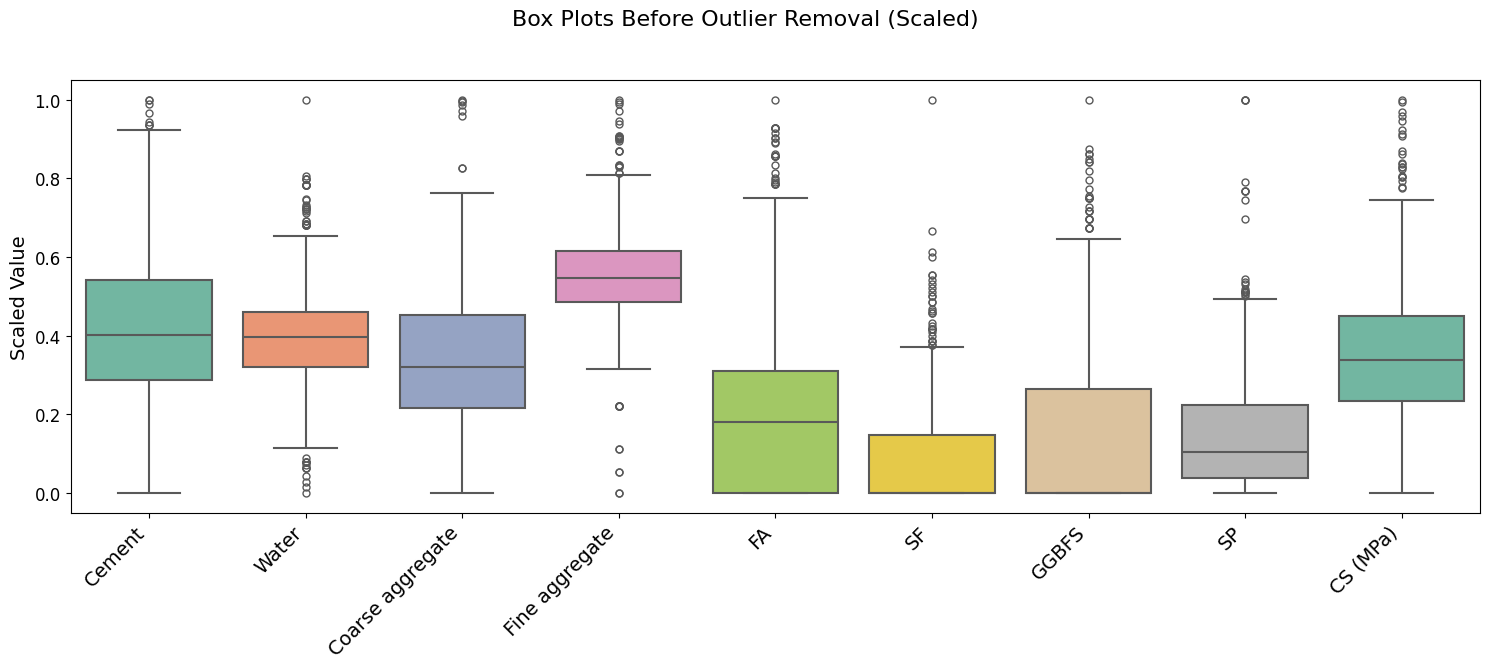

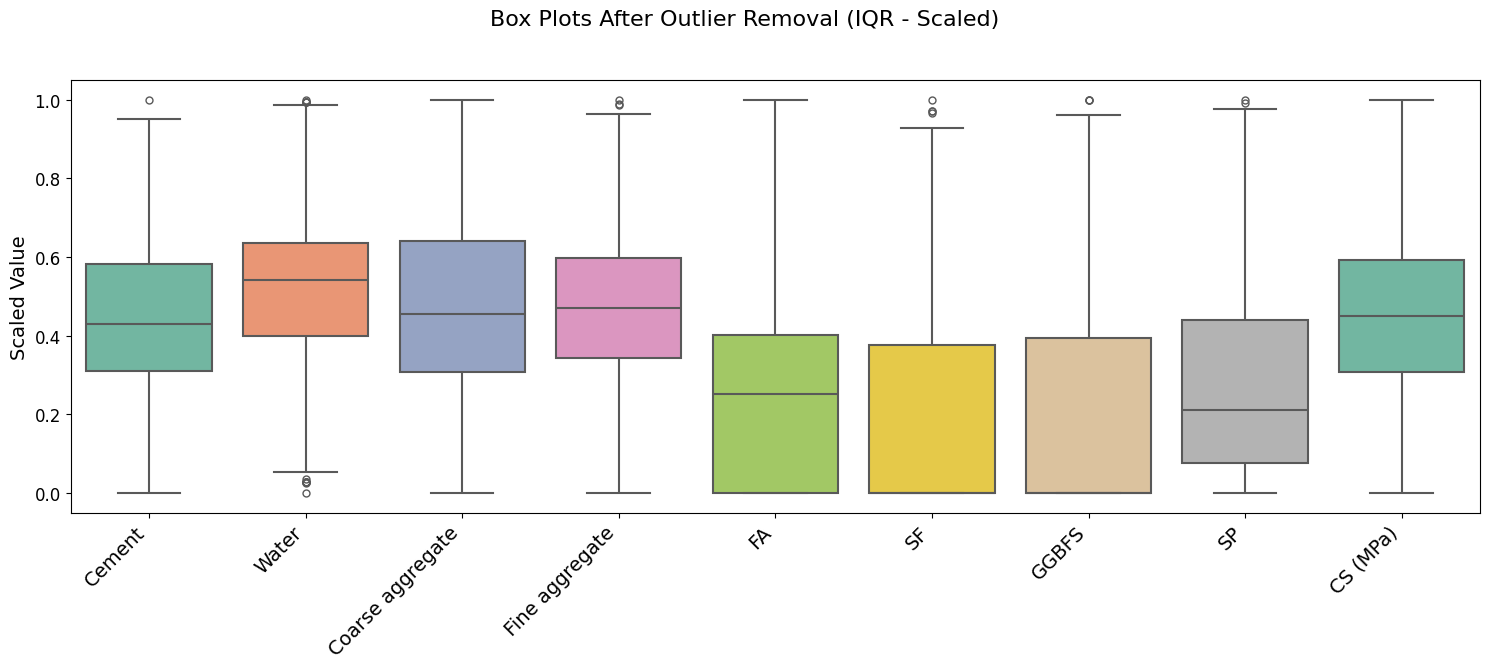

In [ ]:
# Reuse the outlier removal function defined earlier
df_clean_iqr = remove_outliers_iqr(df.copy(), df.columns.tolist())

# Reuse the plotting code defined earlier to show box plots before and after
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# List of numerical columns
num_cols = df.columns.tolist()

# Apply MinMax scaling to original data for visualization
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)

# Plot box plots before outlier removal on a single scale
plt.figure(figsize=(15, 7))
plt.suptitle('Box Plots Before Outlier Removal (Scaled)', fontsize=16)
sns.boxplot(data=df_scaled, orient="v", palette="Set2", fliersize=5, linewidth=1.5)
plt.ylabel("Scaled Value", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=12) # Increased y-tick font size
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Apply MinMax scaling to IQR cleaned data for visualization
scaler_clean_iqr = MinMaxScaler()
df_clean_iqr_scaled = pd.DataFrame(scaler_clean_iqr.fit_transform(df_clean_iqr[num_cols]), columns=num_cols)

# Plot box plots after outlier removal using IQR on a single scale
plt.figure(figsize=(15, 7))
plt.suptitle('Box Plots After Outlier Removal (IQR - Scaled)', fontsize=16)
sns.boxplot(data=df_clean_iqr_scaled, orient="v", palette="Set2", fliersize=5, linewidth=1.5)
plt.ylabel("Scaled Value", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=12) # Increased y-tick font size
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
display(df_clean.describe())

Cement        Water  Coarse aggregate  Fine aggregate  \
count  1281.000000  1281.000000       1281.000000     1281.000000   
mean    305.287564   178.289321        946.284052      760.160648   
std     115.412477    26.910442        193.540856      124.506092   
min      19.000000    99.750000        504.000000      441.600000   
25%     220.000000   160.000000        790.200000      675.000000   
50%     297.500000   181.700000        927.000000      761.000000   
75%     395.250000   196.000000       1100.000000      847.000000   
max     666.000000   251.000000       1432.800000     1120.000000   

                FA           SF        GGBFS           SP     CS (MPa)  
count  1281.000000  1281.000000  1281.000000  1281.000000  1281.000000  
mean     88.206999    18.084019    58.348501     5.650141    46.038752  
std      81.101665    23.250826    78.907957     4.844104    15.820364  
min       0.000000     0.000000     0.000000     0.000000     8.185500  
25%       0.000000     0.000000     0.000000     1.662500    33.720000  
50%      84.600000     0.000000     0.000000     4.560000    45.470000  
75%     135.000000    33.840000   116.600000     9.560000    57.290000  
max     336.000000    90.000000   296.000000    21.700000    91.160000

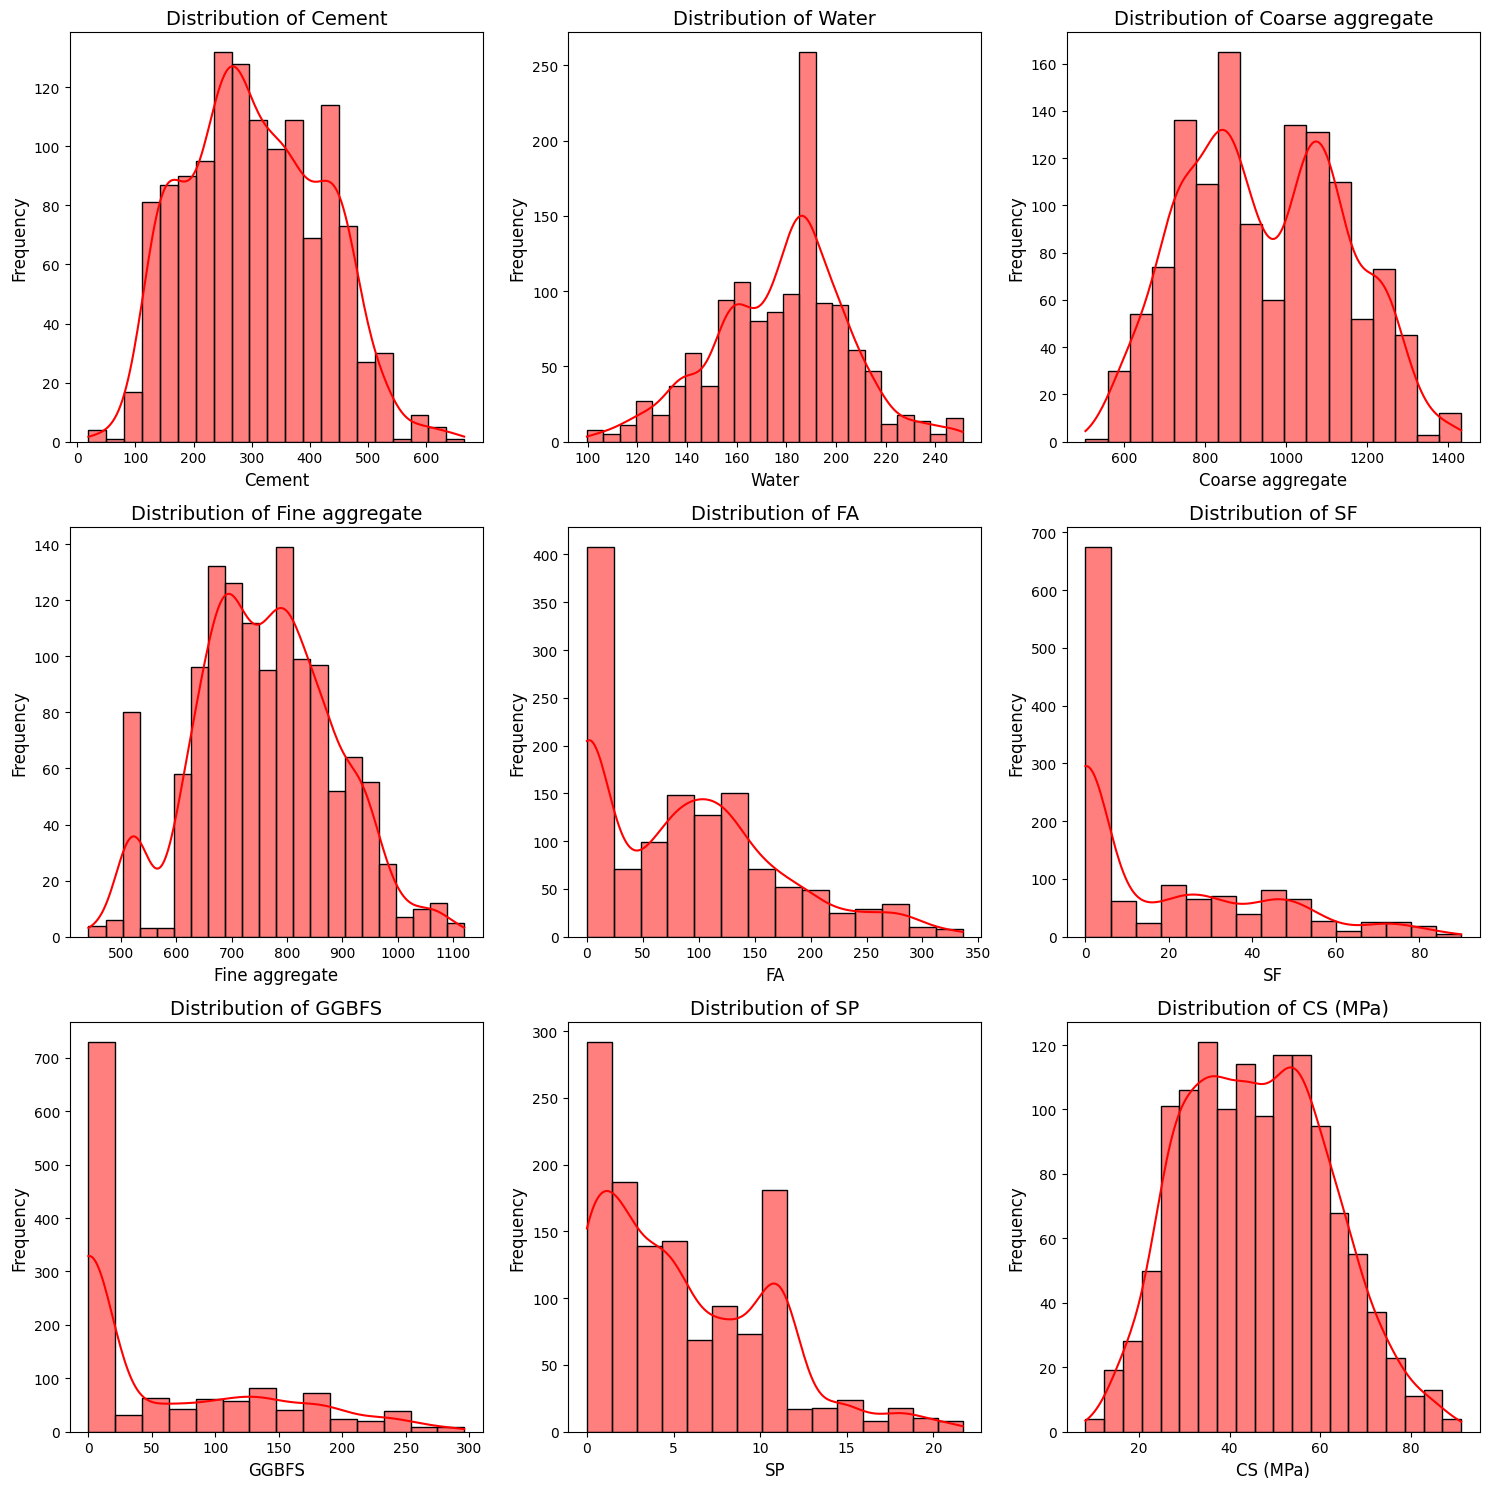

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define features (X) and target (y) again for plotting
X = df_clean.drop(columns=["CS (MPa)"])
y = df_clean["CS (MPa)"]

# Combine features and target for easier plotting
df_plot = df_clean.copy()

# Get the list of columns to plot
cols_to_plot = df_plot.columns.tolist()
n_cols = 3
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 5))

for i, col in enumerate(cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_plot[col], kde=True, color='Red') # Added color='orange'
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

Cement     Water  Coarse aggregate  Fine aggregate  \
Cement            1.000000  0.095303          0.031126       -0.188299   
Water             0.095303  1.000000         -0.330051       -0.009753   
Coarse aggregate  0.031126 -0.330051          1.000000       -0.707675   
Fine aggregate   -0.188299 -0.009753         -0.707675        1.000000   
FA               -0.397363  0.022612         -0.279894        0.053249   
SF                0.221777  0.108653         -0.053168        0.025452   
GGBFS            -0.487670  0.120388         -0.022531        0.026467   
SP                0.289881 -0.077034         -0.232035       -0.013188   
CS (MPa)          0.544710 -0.306083          0.012506       -0.103931   

                        FA        SF     GGBFS        SP  CS (MPa)  
Cement           -0.397363  0.221777 -0.487670  0.289881  0.544710  
Water             0.022612  0.108653  0.120388 -0.077034 -0.306083  
Coarse aggregate -0.279894 -0.053168 -0.022531 -0.232035  0.012506  
Fine aggregate    0.053249  0.025452  0.026467 -0.013188 -0.103931  
FA                1.000000 -0.193139 -0.240799  0.099113 -0.243382  
SF               -0.193139  1.000000 -0.101045  0.091813  0.306550  
GGBFS            -0.240799 -0.101045  1.000000 -0.173632 -0.125397  
SP                0.099113  0.091813 -0.173632  1.000000  0.279082  
CS (MPa)         -0.243382  0.306550 -0.125397  0.279082  1.000000

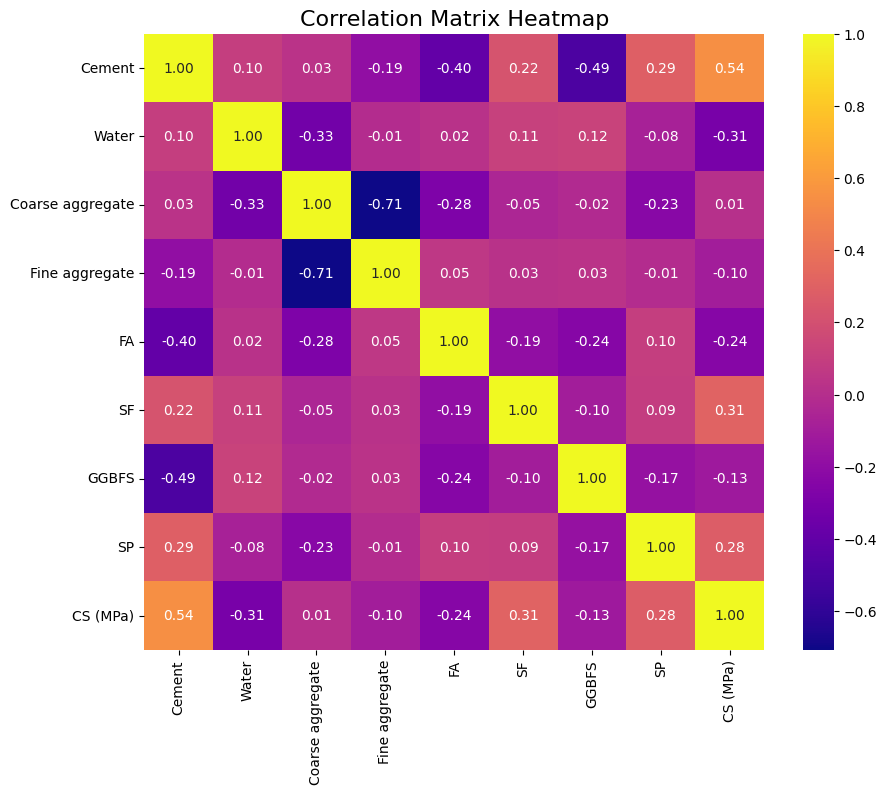

In [ ]:
# Generate and display the correlation matrix
correlation_matrix = df_clean.corr()
display(correlation_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='plasma', fmt=".2f") #'viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable h

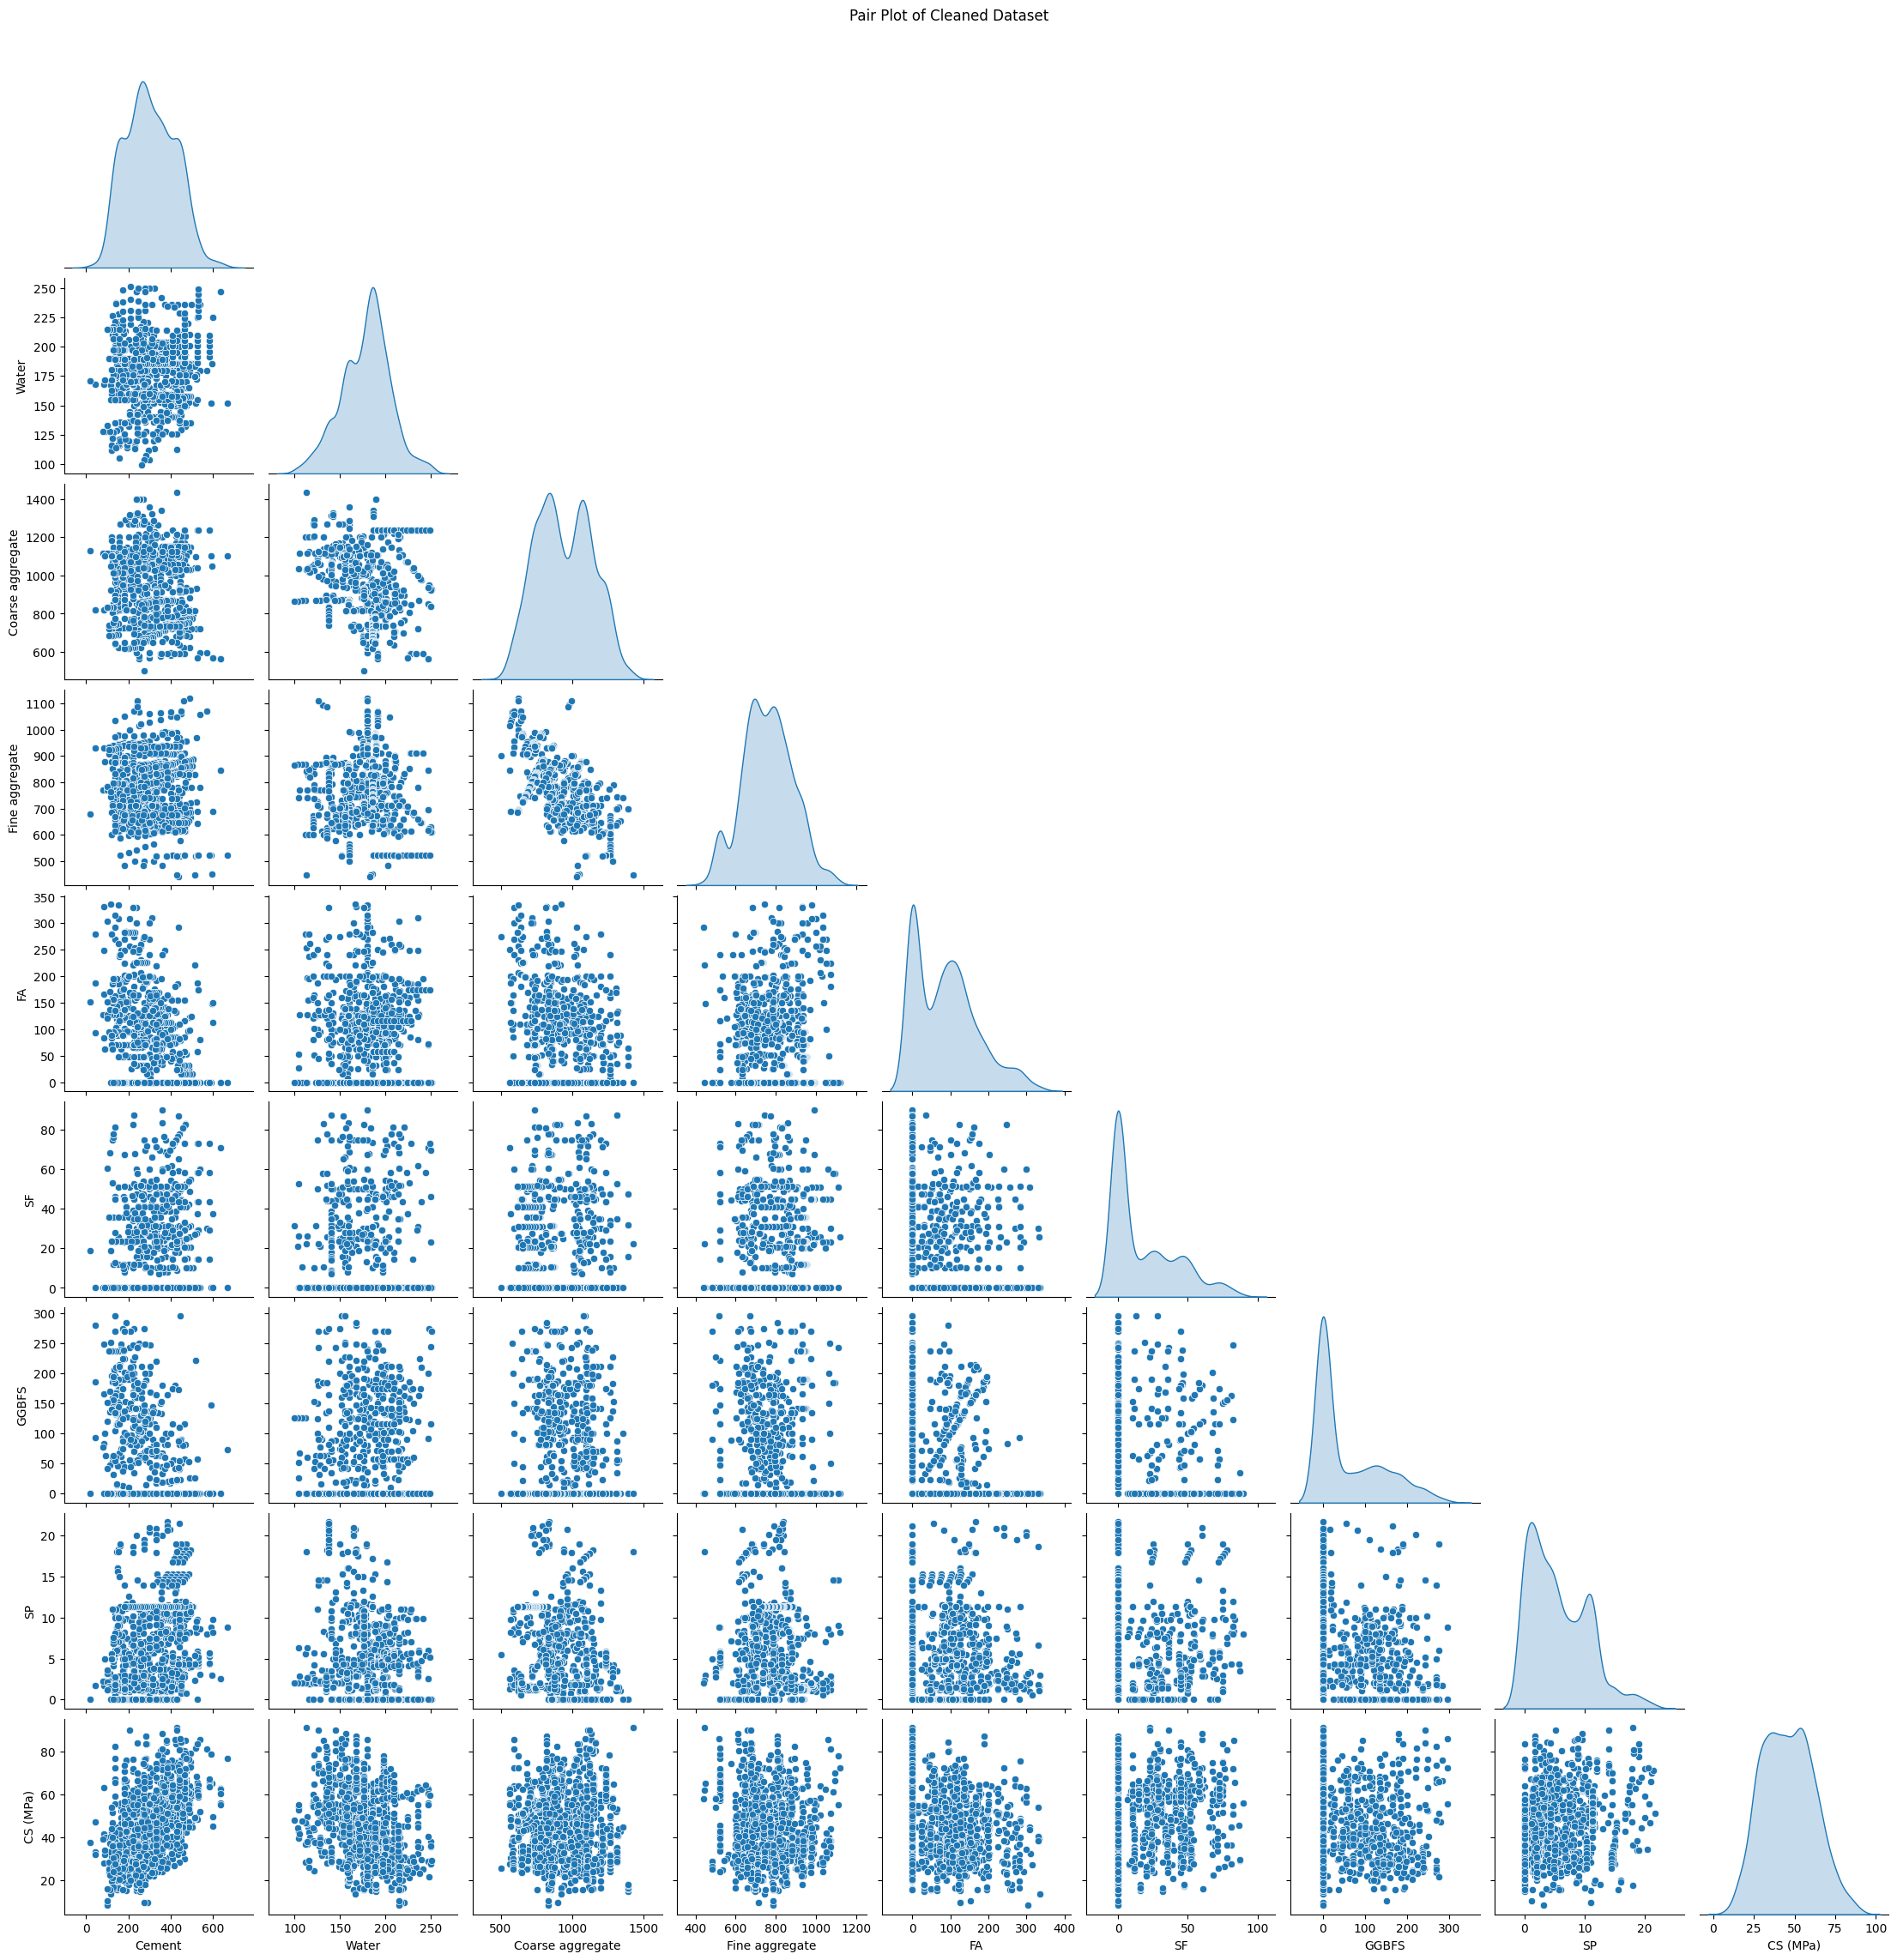

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate a pair plot for the cleaned data
sns.pairplot(df_clean, diag_kind='kde', corner=True, palette='coolwarm') # Changed palette to 'viridis'
plt.suptitle('Pair Plot of Cleaned Dataset', y=1.02) # Add a title
plt.show()

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable h

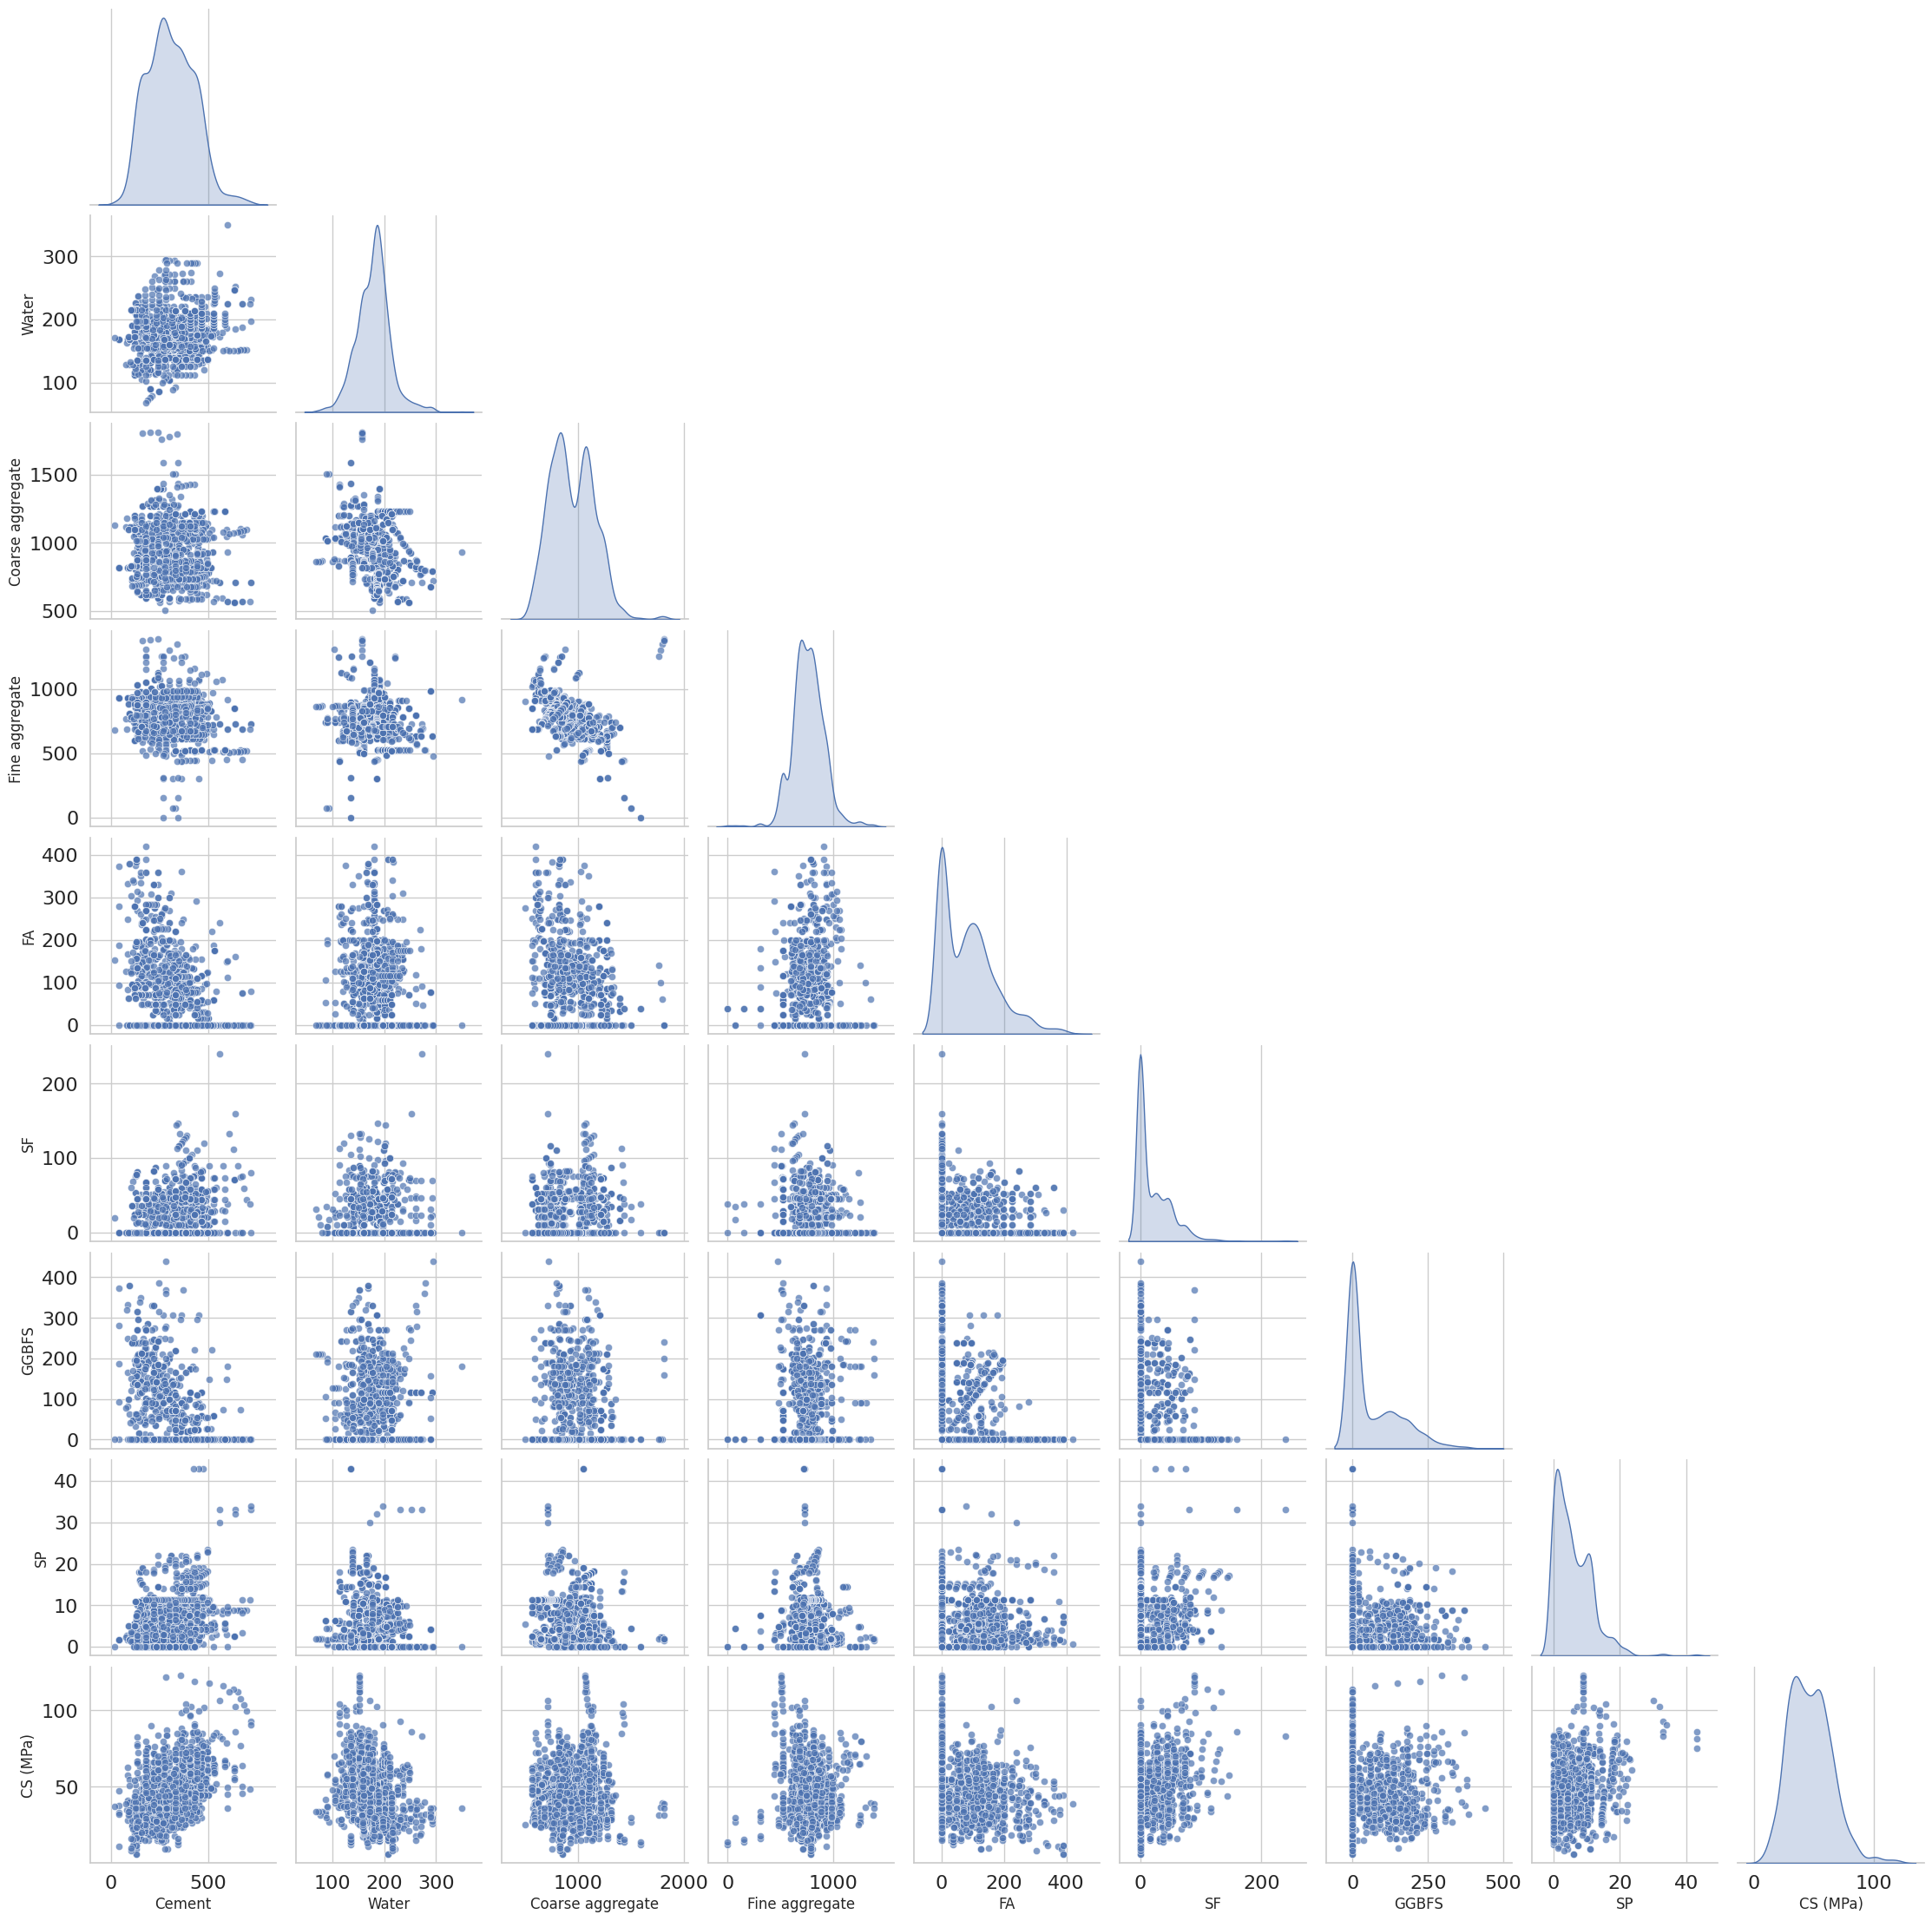

In [ ]:
# ===========================================
# Vibrant Pairplot with Larger Axis Font
# ===========================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is already loaded & preprocessed
# df = pd.read_csv("your_data.csv")

sns.set(style="whitegrid")

# Pairplot with vibrant colors
pairplot = sns.pairplot(
    df,
    diag_kind="kde",
    corner=True,
    palette="husl",
    plot_kws={'alpha':0.7, 's':35}
)

# Adjust font sizes
for ax in pairplot.axes.flatten():
    if ax is not None:  # Some upper triangle axes are None when corner=True
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)

# Title
#plt.suptitle("Vibrant Pairplot of Concrete Mix Ingredients and Compressive Strength",
            # y=1.02, fontsize=18, color="darkblue")

plt.show()


Train set size: (1024, 8)
Test set size: (257, 8)


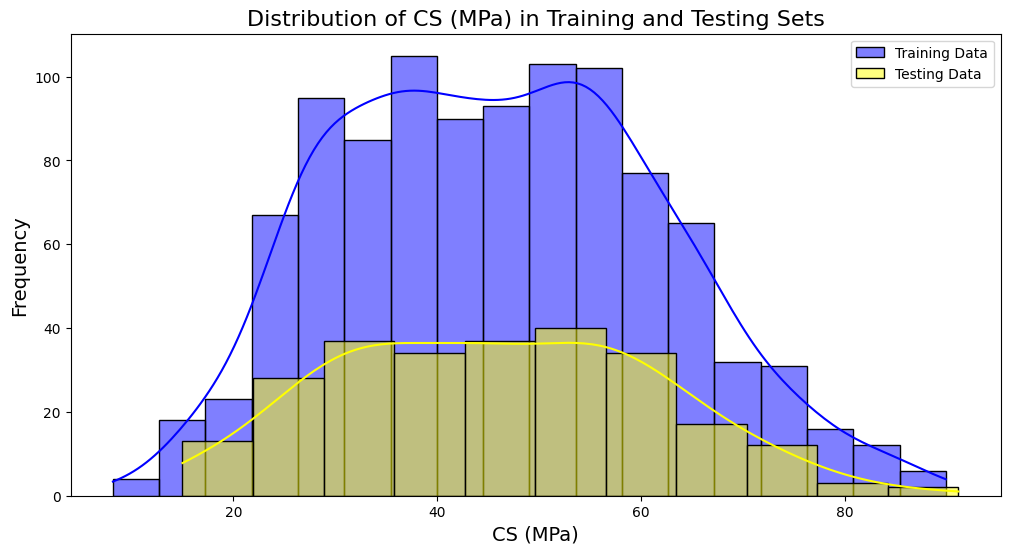

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Distribution plot for training data
sns.histplot(y_train, kde=True, color='blue', label='Training Data')

# Distribution plot for testing data
sns.histplot(y_test, kde=True, color='yellow', label='Testing Data')

plt.title('Distribution of CS (MPa) in Training and Testing Sets', fontsize=16)
plt.xlabel('CS (MPa)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.show()

In [ ]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Initialize models
xgb_model = xgb.XGBRegressor(random_state=42)
cb_model = cb.CatBoostRegressor(random_state=42, verbose=0) # Set verbose to 0 to reduce output
rf_model = RandomForestRegressor(random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42)

models = {
    "XGBoost": xgb_model,
    "CatBoost": cb_model,
    "Random Forest": rf_model,
    "LightGBM": lgb_model
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluation metrics
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)

    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)

    results[name] = {
        "Train R2": r2_train,
        "Train RMSE": rmse_train,
        "Train MAE": mae_train,
        "Test R2": r2_test,
        "Test RMSE": rmse_test,
        "Test MAE": mae_test
    }

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Results:")
display(results_df)

Training XGBoost...
Training CatBoost...
Training Random Forest...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 8
[LightGBM] [Info] Start training from score 46.083033

Model Evaluation Results:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Train R2  Train RMSE  Train MAE   Test R2  Test RMSE  Test MAE
XGBoost        0.989535    1.622438   0.691300  0.848034   6.093272  4.136534
CatBoost       0.965926    2.927537   2.068342  0.879070   5.435569  3.873184
Random Forest  0.967698    2.850389   1.906699  0.839887   6.254472  4.393063
LightGBM       0.964291    2.996980   1.996163  0.862094   5.804560  4.035239

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import time
import pandas as pd # Import pandas for DataFrame

# Define the hyperparameter grid for CatBoost
param_grid = {
    'iterations': [100, 250, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128]
}

print("Hyperparameter grid defined:")
print(param_grid)

# Instantiate a CatBoostRegressor model
cat_model_tune = CatBoostRegressor(verbose=0, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=cat_model_tune, param_grid=param_grid,
                           cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

print("GridSearchCV initialized:")
print(grid_search)

# Perform Grid Search and track time
start_time = time.time()

print("\nStarting Grid Search for CatBoost...")
grid_search.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"\nGrid Search for CatBoost completed in {training_time:.2f} seconds.")

# Get the best model
best_cat_model = grid_search.best_estimator_

print("\nBest hyperparameters found:")
print(grid_search.best_params_)

print("\nBest RMSE during cross-validation:")
print(-grid_search.best_score_)

Hyperparameter grid defined:
{'iterations': [100, 250, 500], 'learning_rate': [0.01, 0.05, 0.1], 'depth': [4, 6, 8], 'l2_leaf_reg': [1, 3, 5], 'border_count': [32, 64, 128]}
GridSearchCV initialized:
GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x78e8a4c6e750>,
             n_jobs=-1,
             param_grid={'border_count': [32, 64, 128], 'depth': [4, 6, 8],
                         'iterations': [100, 250, 500],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_root_mean_squared_error')

Starting Grid Search for CatBoost...

Grid Search for CatBoost completed in 697.00 seconds.

Best hyperparameters found:
{'border_count': 64, 'depth': 4, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

Best RMSE during cross-validation:
6.721780091569512


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Predictions with the best CatBoost model
y_train_pred_cat = best_cat_model.predict(X_train)
y_test_pred_cat = best_cat_model.predict(X_test)

# Evaluate the best CatBoost model
r2_train_cat = r2_score(y_train, y_train_pred_cat)
rmse_train_cat = np.sqrt(mean_squared_error(y_train, y_train_pred_cat))
mae_train_cat = mean_absolute_error(y_train, y_train_pred_cat)

r2_test_cat = r2_score(y_test, y_test_pred_cat)
rmse_test_cat = np.sqrt(mean_squared_error(y_test, y_test_pred_cat))
mae_test_cat = mean_absolute_error(y_test, y_test_pred_cat)

catboost_tuned_results = {
    "Train R2": r2_train_cat,
    "Train RMSE": rmse_train_cat,
    "Train MAE": mae_train_cat,
    "Test R2": r2_test_cat,
    "Test RMSE": rmse_test_cat,
    "Test MAE": mae_test_cat
}

print("Evaluation Results for Tuned CatBoost Model:")
display(pd.DataFrame([catboost_tuned_results], index=["Tuned CatBoost"]))

Evaluation Results for Tuned CatBoost Model:


Train R2  Train RMSE  Train MAE   Test R2  Test RMSE  Test MAE
Tuned CatBoost  0.950641    3.523513   2.555995  0.881622   5.377905  3.767408

In [ ]:
import joblib

# Save the best CatBoost model
joblib.dump(best_cat_model, 'best_catboost_model.pkl')

print("Best CatBoost model saved as 'best_catboost_model.pkl'")

Best CatBoost model saved as 'best_catboost_model.pkl'


In [ ]:
# Define the hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

print("Hyperparameter grid defined for XGBoost:")
print(xgb_param_grid)

Hyperparameter grid defined for XGBoost:
{'n_estimators': [100, 250, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]}


In [ ]:
from sklearn.model_selection import GridSearchCV
import time
import xgboost as xgb

# Instantiate an XGBoostRegressor model
xgb_model_tune = xgb.XGBRegressor(random_state=42)

# Initialize GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_model_tune, param_grid=xgb_param_grid,
                            cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

print("GridSearchCV initialized for XGBoost:")
print(xgb_grid_search)

# Perform Grid Search and track time
start_time = time.time()

print("\nStarting Grid Search for XGBoost...")
xgb_grid_search.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"\nGrid Search for XGBoost completed in {training_time:.2f} seconds.")

# Get the best model
best_xgb_model = xgb_grid_search.best_estimator_

print("\nBest hyperparameters found for XGBoost:")
print(xgb_grid_search.best_params_)

print("\nBest RMSE during cross-validation for XGBoost:")
print(-xgb_grid_search.best_score_)

GridSearchCV initialized for XGBoost:
GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Predictions with the best XGBoost model
y_train_pred_xgb = best_xgb_model.predict(X_train)
y_test_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the best XGBoost model
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
mae_train_xgb = mean_absolute_error(y_train, y_train_pred_xgb)

r2_test_xgb = r2_score(y_test, y_test_pred_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

xgboost_tuned_results = {
    "Train R2": r2_train_xgb,
    "Train RMSE": rmse_train_xgb,
    "Train MAE": mae_train_xgb,
    "Test R2": r2_test_xgb,
    "Test RMSE": rmse_test_xgb,
    "Test MAE": mae_test_xgb
}

print("Evaluation Results for Tuned XGBoost Model:")
display(pd.DataFrame([xgboost_tuned_results], index=["Tuned XGBoost"]))

Evaluation Results for Tuned XGBoost Model:


Train R2  Train RMSE  Train MAE   Test R2  Test RMSE  Test MAE
Tuned XGBoost  0.962198    3.083534   2.209722  0.870063   5.634339  3.940964

In [ ]:
# Define the hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

print("Hyperparameter grid defined for Random Forest:")
print(rf_param_grid)

Hyperparameter grid defined for Random Forest:
{'n_estimators': [100, 250, 500], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import time

# Instantiate a RandomForestRegressor model
rf_model_tune = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_model_tune, param_grid=rf_param_grid,
                            cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

print("GridSearchCV initialized for Random Forest:")
print(rf_grid_search)

# Perform Grid Search and track time
start_time = time.time()

print("\nStarting Grid Search for Random Forest...")
rf_grid_search.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"\nGrid Search for Random Forest completed in {training_time:.2f} seconds.")

# Get the best model
best_rf_model = rf_grid_search.best_estimator_

print("\nBest hyperparameters found for Random Forest:")
print(rf_grid_search.best_params_)

print("\nBest RMSE during cross-validation for Random Forest:")
print(-rf_grid_search.best_score_)

GridSearchCV initialized for Random Forest:
GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='neg_root_mean_squared_error')

Starting Grid Search for Random Forest...

Grid Search for Random Forest completed in 1339.46 seconds.

Best hyperparameters found for Random Forest:
{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}

Best RMSE during cross-validation for Random Forest:
7.730225809459431


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Predictions with the best Random Forest model
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

# Evaluate the best Random Forest model
r2_train_rf = r2_score(y_train, y_train_pred_rf)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)

r2_test_rf = r2_score(y_test, y_test_pred_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

random_forest_tuned_results = {
    "Train R2": r2_train_rf,
    "Train RMSE": rmse_train_rf,
    "Train MAE": mae_train_rf,
    "Test R2": r2_test_rf,
    "Test RMSE": rmse_test_rf,
    "Test MAE": mae_test_rf
}

print("Evaluation Results for Tuned Random Forest Model:")
display(pd.DataFrame([random_forest_tuned_results], index=["Tuned Random Forest"]))

Evaluation Results for Tuned Random Forest Model:


Train R2  Train RMSE  Train MAE   Test R2  Test RMSE  \
Tuned Random Forest  0.969099    2.787891    1.87171  0.840209   6.248179   

                     Test MAE  
Tuned Random Forest  4.413602

In [ ]:
# Define the hyperparameter grid for LightGBM
lgb_param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 10, 20],
    'num_leaves': [31, 64, 128],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

print("Hyperparameter grid defined for LightGBM:")
print(lgb_param_grid)

Hyperparameter grid defined for LightGBM:
{'n_estimators': [100, 250, 500], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [-1, 10, 20], 'num_leaves': [31, 64, 128], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]}


In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import time

# Instantiate a LGBMRegressor model
lgb_model_tune = LGBMRegressor(random_state=42)

# Initialize GridSearchCV
lgb_grid_search = GridSearchCV(estimator=lgb_model_tune, param_grid=lgb_param_grid,
                            cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

print("GridSearchCV initialized for LightGBM:")
print(lgb_grid_search)

# Perform Grid Search and track time
start_time = time.time()

print("\nStarting Grid Search for LightGBM...")
lgb_grid_search.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time

print(f"\nGrid Search for LightGBM completed in {training_time:.2f} seconds.")

# Get the best model
best_lgb_model = lgb_grid_search.best_estimator_

print("\nBest hyperparameters found for LightGBM:")
print(lgb_grid_search.best_params_)

print("\nBest RMSE during cross-validation for LightGBM:")
print(-lgb_grid_search.best_score_)

GridSearchCV initialized for LightGBM:
GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20],
                         'n_estimators': [100, 250, 500],
                         'num_leaves': [31, 64, 128],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_root_mean_squared_error')

Starting Grid Search for LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 1024, number of used features: 8
[LightGBM] [Info] Start training from score 46.083033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Predictions with the best LightGBM model
y_train_pred_lgb = best_lgb_model.predict(X_train)
y_test_pred_lgb = best_lgb_model.predict(X_test)

# Evaluate the best LightGBM model
r2_train_lgb = r2_score(y_train, y_train_pred_lgb)
rmse_train_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
mae_train_lgb = mean_absolute_error(y_train, y_train_pred_lgb)

r2_test_lgb = r2_score(y_test, y_test_pred_lgb)
rmse_test_lgb = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
mae_test_lgb = mean_absolute_error(y_test, y_test_pred_lgb)

lightgbm_tuned_results = {
    "Train R2": r2_train_lgb,
    "Train RMSE": rmse_train_lgb,
    "Train MAE": mae_train_lgb,
    "Test R2": r2_test_lgb,
    "Test RMSE": rmse_test_lgb,
    "Test MAE": mae_test_lgb
}

print("Evaluation Results for Tuned LightGBM Model:")
display(pd.DataFrame([lightgbm_tuned_results], index=["Tuned LightGBM"]))

Evaluation Results for Tuned LightGBM Model:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Train R2  Train RMSE  Train MAE   Test R2  Test RMSE  Test MAE
Tuned LightGBM  0.979292    2.282231   1.381007  0.870345   5.628242  3.714289

In [ ]:
import pandas as pd

# Combine the results from all tuned models into a single dictionary
all_tuned_results = {
    "Tuned CatBoost": catboost_tuned_results,
    "Tuned XGBoost": xgboost_tuned_results,
    "Tuned Random Forest": random_forest_tuned_results,
    "Tuned LightGBM": lightgbm_tuned_results
}

# Create a DataFrame from the combined results
all_tuned_results_df = pd.DataFrame(all_tuned_results).T

print("Comparison of Tuned Model Evaluation Results:")
display(all_tuned_results_df)

Comparison of Tuned Model Evaluation Results:


Train R2  Train RMSE  Train MAE   Test R2  Test RMSE  \
Tuned CatBoost       0.950641    3.523513   2.555995  0.881622   5.377905   
Tuned XGBoost        0.962198    3.083534   2.209722  0.870063   5.634339   
Tuned Random Forest  0.969099    2.787891   1.871710  0.840209   6.248179   
Tuned LightGBM       0.979292    2.282231   1.381007  0.870345   5.628242   

                     Test MAE  
Tuned CatBoost       3.767408  
Tuned XGBoost        3.940964  
Tuned Random Forest  4.413602  
Tuned LightGBM       3.714289

In [ ]:
import joblib
import pandas as pd

# Save the best models
joblib.dump(best_cat_model, 'best_catboost_model.pkl')
joblib.dump(best_xgb_model, 'best_xgboost_model.pkl')
joblib.dump(best_rf_model, 'best_random_forest_model.pkl')
joblib.dump(best_lgb_model, 'best_lightgbm_model.pkl')

print("All best models saved.")

# Save the training and testing data
# Convert scaled X_train and X_test back to DataFrames with original column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

X_train_df.to_csv('X_train.csv', index=False)
X_test_df.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Training and testing data saved as CSV files.")

NameError: name 'best_cat_model' is not defined

In [ ]:
!pip install joblib
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
import joblib
import pandas as pd

# Load the saved models
loaded_catboost_model = joblib.load('best_catboost_model.pkl')
loaded_xgboost_model = joblib.load('best_xgboost_model.pkl')
# loaded_random_forest_model = joblib.load('best_random_forest_model.pkl')
loaded_lightgbm_model = joblib.load('best_lightgbm_model.pkl')

print("All models loaded successfully.")

# Load the saved training and testing data
loaded_X_train = pd.read_csv('X_train.csv')
loaded_X_test = pd.read_csv('X_test.csv')
loaded_y_train = pd.read_csv('y_train.csv')
loaded_y_test = pd.read_csv('y_test.csv')

print("Training and testing data loaded successfully.")



All models loaded successfully.
Training and testing data loaded successfully.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Test R2  Train R2  Test RMSE  Train RMSE  Test MAE  \
Tuned CatBoost       0.881622  0.950641   5.377905    3.523513  3.767408   
Tuned XGBoost        0.870063  0.962198   5.634339    3.083534  3.940964   
Tuned Random Forest  0.840209  0.969099   6.248179    2.787891  4.413602   
Tuned LightGBM       0.870345  0.979292   5.628242    2.282231  3.714289   

                     Train MAE  
Tuned CatBoost        2.555995  
Tuned XGBoost         2.209722  
Tuned Random Forest   1.871710  
Tuned LightGBM        1.381007

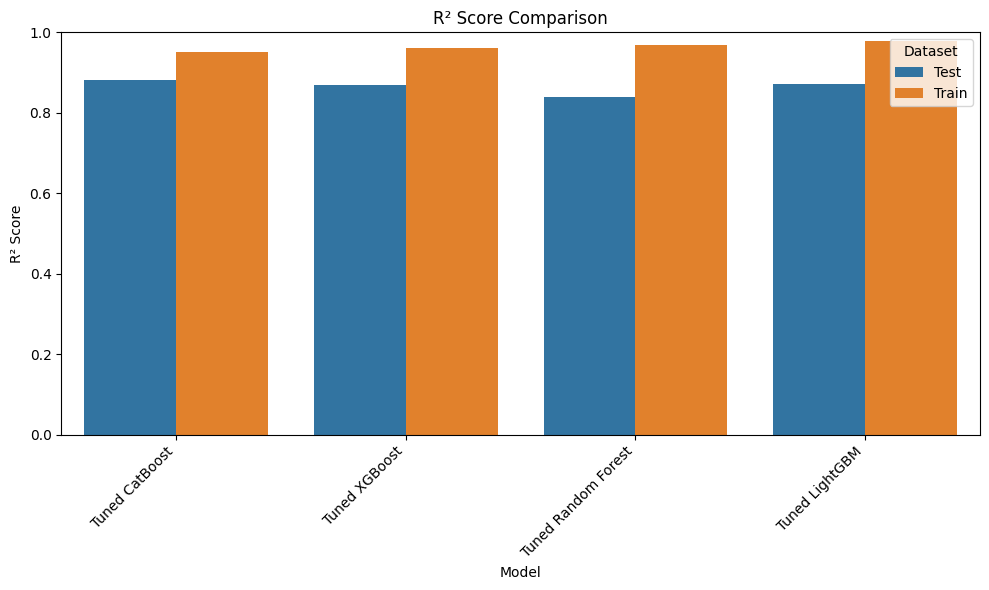

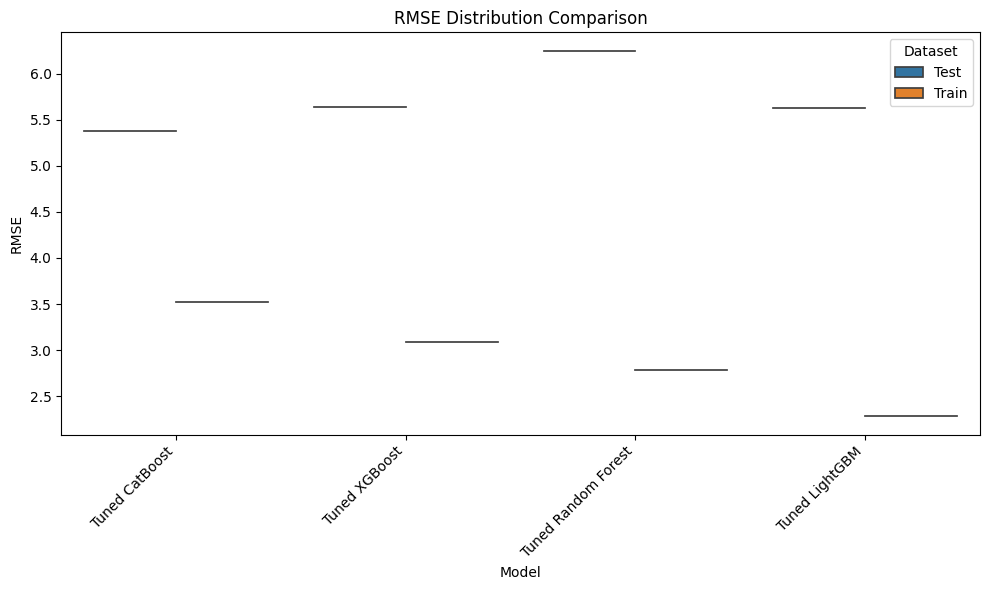

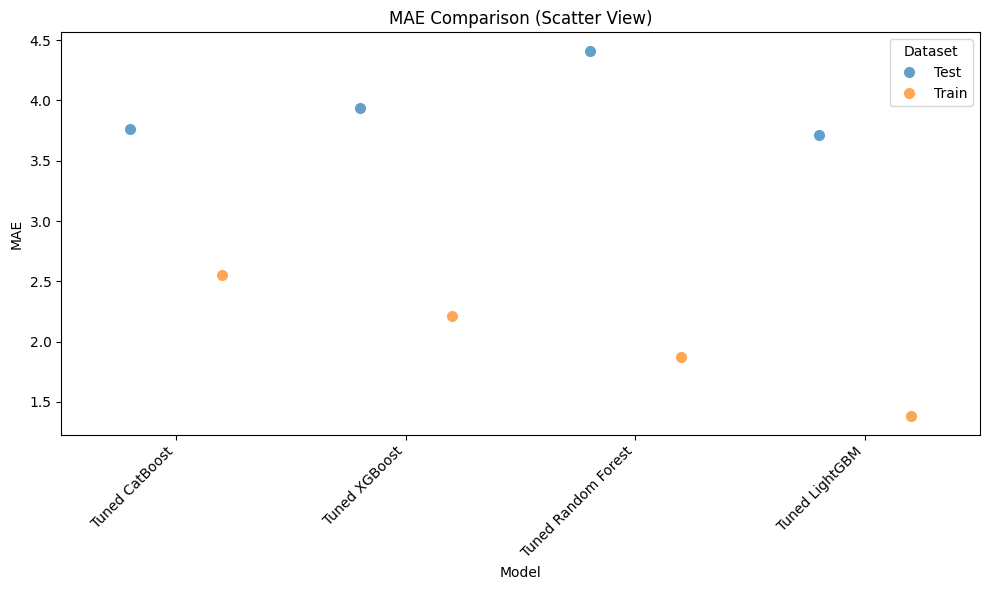

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


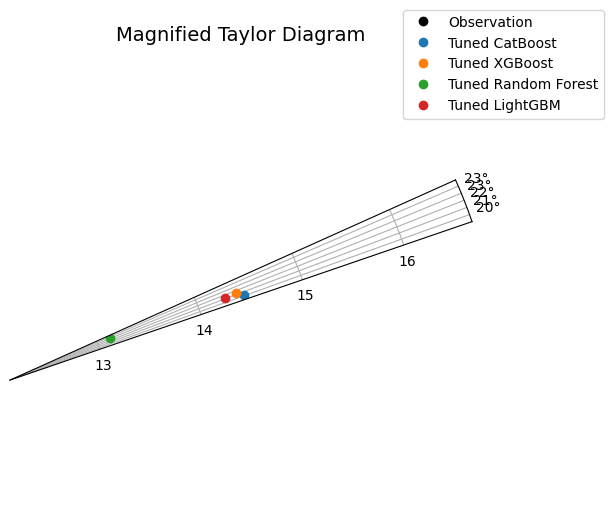

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Evaluation of loaded models ===
loaded_models_results = {}

loaded_models = {
    "Tuned CatBoost": loaded_catboost_model,
    "Tuned XGBoost": loaded_xgboost_model,
    "Tuned Random Forest": loaded_random_forest_model,
    "Tuned LightGBM": loaded_lightgbm_model
}

for name, model in loaded_models.items():
    # Predictions
    y_test_pred = model.predict(loaded_X_test)
    y_train_pred = model.predict(loaded_X_train)

    # Metrics
    r2_test = r2_score(loaded_y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(loaded_y_test, y_test_pred))
    mae_test = mean_absolute_error(loaded_y_test, y_test_pred)

    r2_train = r2_score(loaded_y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(loaded_y_train, y_train_pred))
    mae_train = mean_absolute_error(loaded_y_train, y_train_pred)

    loaded_models_results[name] = {
        "Test R2": r2_test, "Train R2": r2_train,
        "Test RMSE": rmse_test, "Train RMSE": rmse_train,
        "Test MAE": mae_test, "Train MAE": mae_train
    }

# Convert to DataFrame
loaded_results_df = pd.DataFrame(loaded_models_results).T
display(loaded_results_df)

# Melt for seaborn plotting
loaded_results_melted = loaded_results_df.reset_index().melt(id_vars='index',
                            var_name='Metric', value_name='Score')
loaded_results_melted[['Dataset','Metric_Name']] = \
    loaded_results_melted['Metric'].str.split(' ', expand=True)


# ============ R2 Comparison ============
plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='Score', hue='Dataset',
            data=loaded_results_melted[loaded_results_melted['Metric_Name'] == 'R2'])
plt.title('R² Score Comparison')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# ============ RMSE Comparison ============
plt.figure(figsize=(10, 6))
sns.violinplot(x='index', y='Score', hue='Dataset',
               data=loaded_results_melted[loaded_results_melted['Metric_Name'] == 'RMSE'],
               split=True, inner="quart")
plt.title('RMSE Distribution Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

# ============ MAE Comparison ============
plt.figure(figsize=(10, 6))
sns.stripplot(x='index', y='Score', hue='Dataset',
              data=loaded_results_melted[loaded_results_melted['Metric_Name'] == 'MAE'],
              dodge=True, size=8, alpha=0.7)
plt.title('MAE Comparison (Scatter View)')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


# ============ Taylor Diagram ============
def taylor_diagram(ref, models_dict):
    """
    Create a Taylor diagram comparing models to reference values
    ref: reference observations (y_test)
    models_dict: dict of {model_name: predictions}
    """
    std_ref = np.std(ref)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    # Reference point
    ax.plot(0, std_ref, 'ko', markersize=12, label="Reference")

    for name, preds in models_dict.items():
        std_model = np.std(preds)
        corr_coef = np.corrcoef(ref, preds)[0,1]
        theta = np.arccos(corr_coef)
        ax.plot(theta, std_model, 'o', markersize=10, label=name)

    # Add grid and labels
    ax.set_title("Taylor Diagram", fontsize=14)
    ax.set_xlabel("Correlation")
    ax.set_ylabel("Standard Deviation")
    ax.grid(True)
    ax.legend(loc='best', bbox_to_anchor=(1.2, 1.05))

    plt.show()
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def taylor_diagram(obs, model_preds, zoom_factor=0.3):
    """
    Create a Taylor diagram with zooming option.

    obs : array-like (n_samples,)
        Observed values
    model_preds : dict of {model_name: y_pred}
        Predictions from models
    zoom_factor : float
        Fraction of the axis range to zoom (smaller = more zoom-in)
    """
    obs = np.ravel(obs)
    std_obs = np.std(obs, ddof=1)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, polar=True)

    # Reference point (observation)
    ax.plot(0, std_obs, 'ko', label='Observation')

    # Store ranges for zooming
    stds, cors = [], []
    for name, pred in model_preds.items():
        pred = np.ravel(pred)
        std_pred = np.std(pred, ddof=1)
        corr = np.corrcoef(obs, pred)[0, 1]
        theta = np.arccos(corr)
        ax.plot(theta, std_pred, 'o', label=name)
        stds.append(std_pred)
        cors.append(corr)

    # Set zoomed limits
    min_std, max_std = min(stds + [std_obs]), max(stds + [std_obs])
    std_range = (max_std - min_std) * zoom_factor
    ax.set_rlim(min_std - std_range, max_std + std_range)

    min_corr, max_corr = min(cors), max(cors)
    theta_min = np.degrees(np.arccos(max_corr))  # high correlation → low angle
    theta_max = np.degrees(np.arccos(min_corr))
    theta_range = (theta_max - theta_min) * zoom_factor
    ax.set_thetamin(theta_min - theta_range)
    ax.set_thetamax(theta_max + theta_range)

    ax.set_title("Magnified Taylor Diagram", fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()


# Example usage with your models
model_preds = {name: np.ravel(model.predict(loaded_X_test))
               for name, model in loaded_models.items()}

taylor_diagram(np.ravel(loaded_y_test), model_preds, zoom_factor=0.4)




/tmp/ipython-input-3089933834.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-3089933834.py:45: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


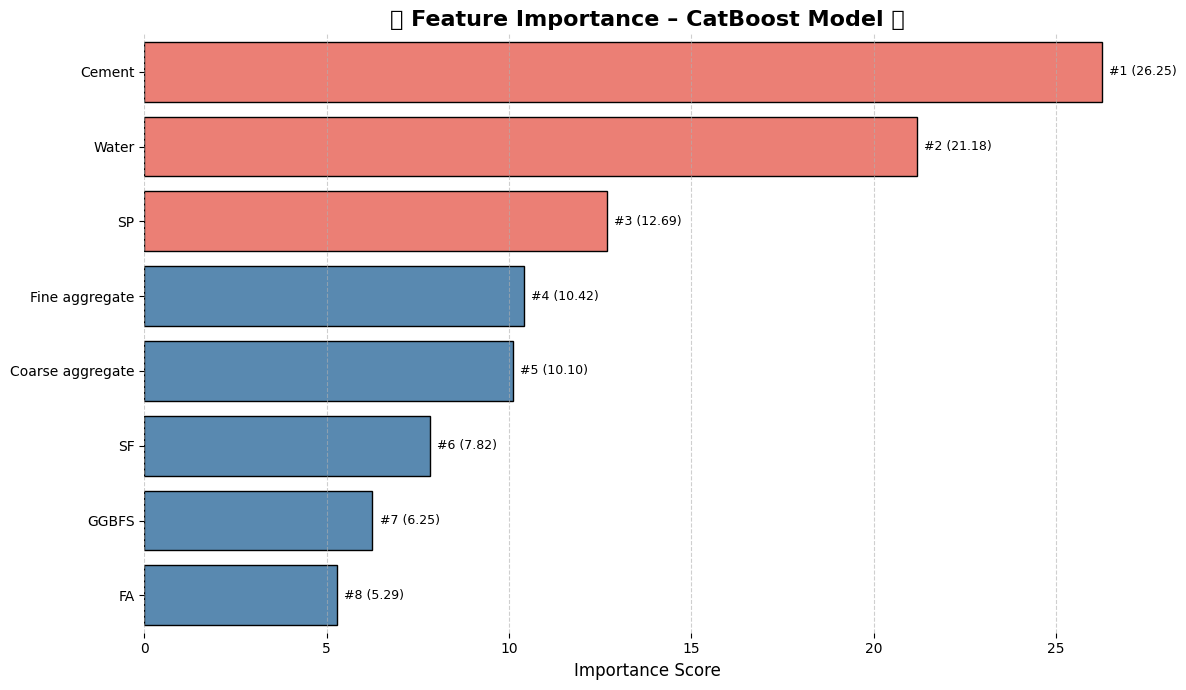

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importance from CatBoost
feature_importance = loaded_catboost_model.get_feature_importance()
feature_names = loaded_X_test.columns

# Create dataframe for plotting
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance
}).sort_values("Importance", ascending=False).reset_index(drop=True)

# Rank for annotation
importance_df["Rank"] = importance_df.index + 1

# Colors: Highlight top 3
colors = ["#FF6F61" if i < 3 else "#4B8BBE" for i in range(len(importance_df))]

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(
    x="Importance", y="Feature",
    data=importance_df,
    palette=colors,
    edgecolor="black"
)

# Annotate with rank + value
for i, (imp, feat, rank) in enumerate(zip(importance_df["Importance"],
                                          importance_df["Feature"],
                                          importance_df["Rank"])):
    plt.text(imp + 0.2, i, f"#{rank} ({imp:.2f})", va="center", fontsize=9)

# Style adjustments
plt.title("✨ Feature Importance – CatBoost Model ✨", fontsize=16, weight="bold")
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("")
sns.despine(left=True, bottom=True)

# Light grid background
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


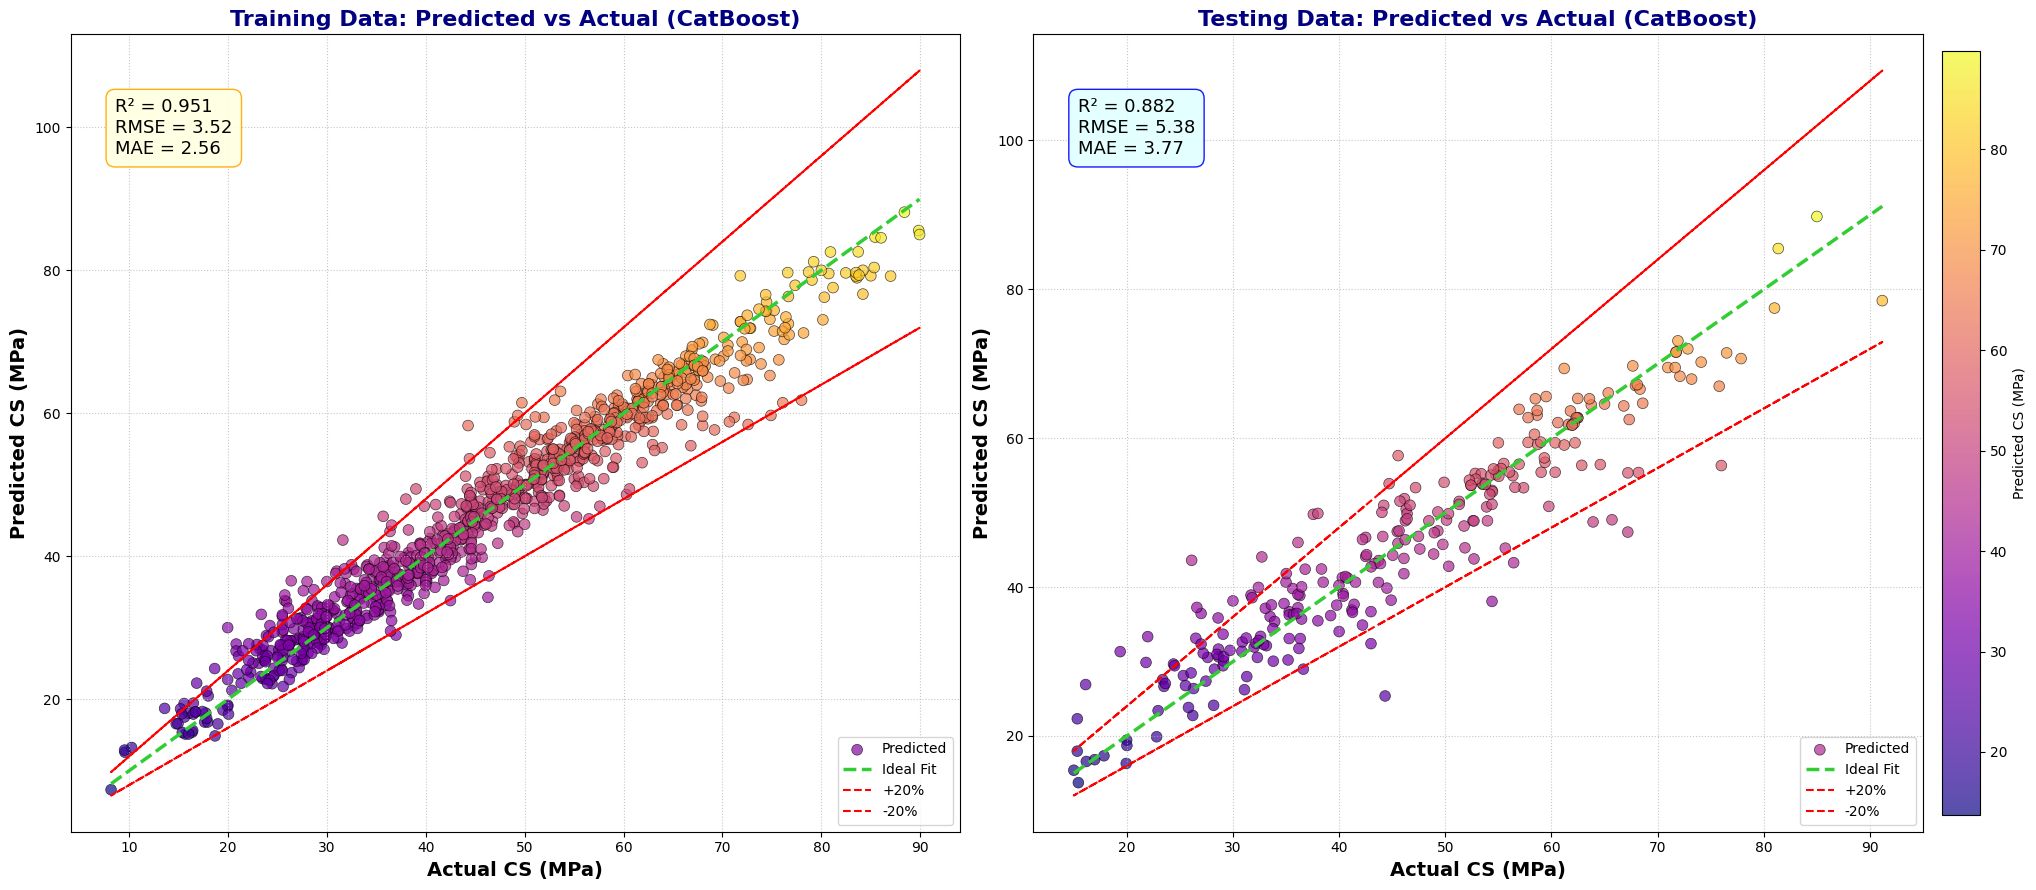

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Predictions for both train and test sets using the best CatBoost model
y_train_pred = loaded_catboost_model.predict(loaded_X_train)
y_test_pred = loaded_catboost_model.predict(loaded_X_test)

# Calculate metrics for train and test sets
r2_train = r2_score(loaded_y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(loaded_y_train, y_train_pred))
mae_train = mean_absolute_error(loaded_y_train, y_train_pred)

r2_test = r2_score(loaded_y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(loaded_y_test, y_test_pred))
mae_test = mean_absolute_error(loaded_y_test, y_test_pred)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Define vibrant colormap
cmap = plt.cm.plasma

# --- Training Data ---
ax1 = axes[0]
sc1 = ax1.scatter(loaded_y_train, y_train_pred,
                  c=y_train_pred, cmap=cmap,
                  s=60, alpha=0.7, edgecolors="k", linewidth=0.5, label='Predicted')

# Ideal Fit line
ax1.plot([loaded_y_train.min(), loaded_y_train.max()],
         [loaded_y_train.min(), loaded_y_train.max()],
         color="limegreen", lw=2.5, linestyle="--", label="Ideal Fit")

# Add ±20% bounds
ax1.plot(loaded_y_train, loaded_y_train * 1.20, color="red", lw=1.5, linestyle="--", label="+20%")
ax1.plot(loaded_y_train, loaded_y_train * 0.80, color="red", lw=1.5, linestyle="--", label="-20%")

ax1.set_xlabel("Actual CS (MPa)", fontsize=14, fontweight="bold")
ax1.set_ylabel("Predicted CS (MPa)", fontsize=14, fontweight="bold")
ax1.set_title("Training Data: Predicted vs Actual (CatBoost)", fontsize=16, fontweight="bold", color="navy")
ax1.grid(True, linestyle=":", alpha=0.7)
ax1.legend()

# Metrics box
metrics_text_train = f"R² = {r2_train:.3f}\nRMSE = {rmse_train:.2f}\nMAE = {mae_train:.2f}"
ax1.annotate(metrics_text_train, xy=(0.05, 0.85), xycoords="axes fraction", fontsize=13,
             bbox=dict(boxstyle="round,pad=0.5", fc="lightyellow", ec="orange", alpha=0.9))

# --- Testing Data ---
ax2 = axes[1]
sc2 = ax2.scatter(loaded_y_test, y_test_pred,
                  c=y_test_pred, cmap=cmap,
                  s=60, alpha=0.7, edgecolors="k", linewidth=0.5, label='Predicted')

ax2.plot([loaded_y_test.min(), loaded_y_test.max()],
         [loaded_y_test.min(), loaded_y_test.max()],
         color="limegreen", lw=2.5, linestyle="--", label="Ideal Fit")

ax2.plot(loaded_y_test, loaded_y_test * 1.20, color="red", lw=1.5, linestyle="--", label="+20%")
ax2.plot(loaded_y_test, loaded_y_test * 0.80, color="red", lw=1.5, linestyle="--", label="-20%")

ax2.set_xlabel("Actual CS (MPa)", fontsize=14, fontweight="bold")
ax2.set_ylabel("Predicted CS (MPa)", fontsize=14, fontweight="bold")
ax2.set_title("Testing Data: Predicted vs Actual (CatBoost)", fontsize=16, fontweight="bold", color="navy")
ax2.grid(True, linestyle=":", alpha=0.7)
ax2.legend()

# Metrics box
metrics_text_test = f"R² = {r2_test:.3f}\nRMSE = {rmse_test:.2f}\nMAE = {mae_test:.2f}"
ax2.annotate(metrics_text_test, xy=(0.05, 0.85), xycoords="axes fraction", fontsize=13,
             bbox=dict(boxstyle="round,pad=0.5", fc="lightcyan", ec="blue", alpha=0.9))

plt.tight_layout()
plt.colorbar(sc2, ax=axes, orientation="vertical", fraction=0.02, pad=0.01, label="Predicted CS (MPa)")
plt.show()


In [ ]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.8 MB/s eta 0:00:00


Loaded CatBoost model from: best_catboost_model.pkl
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      250 |      1 |  0.000000E+00 |  1.725266E+01 |             - |             -
     2 |      500 |      2 |  0.000000E+00 |  0.0828691718 |  1.0000000000 |         ideal
     3 |      750 |      2 |  0.000000E+00 |  0.0299881673 |  0.7706093805 |         ideal
     4 |     1000 |      2 |  0.000000E+00 |  0.0083665193 |  0.8292470612 |         nadir
     5 |     1250 |      2 |  0.000000E+00 |  0.0012147814 |  0.5882361237 |         ideal
     6 |     1500 |      2 |  0.000000E+00 |  0.000000E+00 |  0.4576252968 |         ideal
     7 |     1750 |      2 |  0.000000E+00 |  0.000000E+00 |  0.6786417340 |         ideal
     8 |     2000 |      6 |  0.000000E+00 |  0.000000E+00 |  0.4943980594 |         ideal
     9 |     2250 |      7 |  0.000000E+00 |  0.000000E+00 |  0.0287206989 |             f
    10 |     2500 |      4 |  0.000000

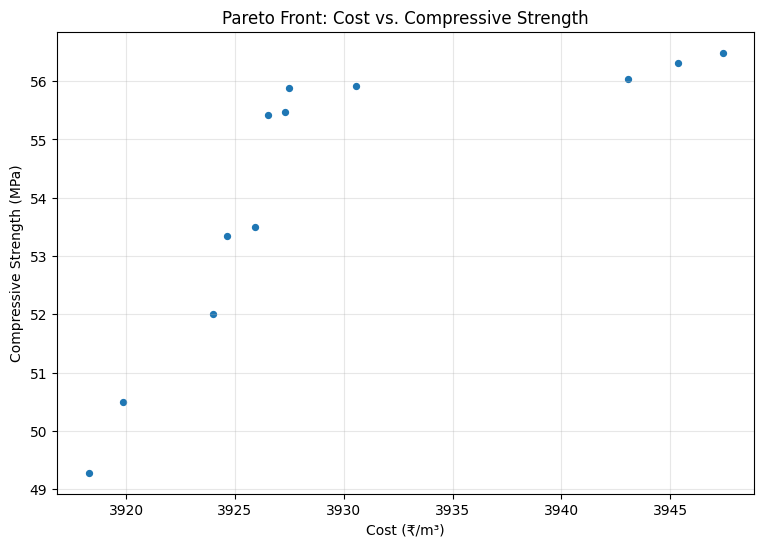


=== TOPSIS Selection (from Pareto set) ===
Best index: 5, Score: 0.9472
  Cement            :   100.00 kg/m³
  Water             :   150.02 kg/m³
  Coarse aggregate  :  1254.07 kg/m³
  Fine aggregate    :   538.16 kg/m³
  FA                :    89.33 kg/m³
  SF                :     0.40 kg/m³
  GGBFS             :   110.31 kg/m³
  SP                :     0.10 kg/m³
  Cost (₹/m³)      :  3947.40
  Strength (MPa)   :    56.49
  Constraints OK   : True


In [ ]:
# === MOO for Concrete Mix Design (NSGA-II + TOPSIS) ===
# Requirements: pymoo, joblib, numpy, pandas, matplotlib, scikit-learn
# pip install -q pymoo joblib numpy pandas matplotlib scikit-learn

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# ---------------------------
# Config: Costs (₹/kg) & Densities (kg/m³)
# ---------------------------
material_names = [
    'Cement','Water','Coarse aggregate','Fine aggregate','FA','SF','GGBFS','SP'
]

# Costs in ₹/kg (mid-2025 UP estimates) — edit to your market prices
unit_costs = {
    'Cement': 10,          # ₹/kg
    'Water': 0.001,        # ₹/kg
    'Coarse aggregate': 0.9,
    'Fine aggregate': 1.8,
    'FA': 3.00,
    'SF': 45.0,
    'GGBFS': 5,
    'SP': 120.0
}

# Densities (kg/m³) — typical values (used for volume constraint)
densities = {
    'Cement': 3150, 'Water': 1000, 'Coarse aggregate': 2600, 'Fine aggregate': 2600,
    'FA': 2200, 'SF': 2200, 'GGBFS': 2900, 'SP': 1100
}

# Variable bounds (kg/m³) — wide; constraints will enforce feasibility
bounds_lower = [100, 120, 700, 500, 0,   0,   0,  0]
bounds_upper = [550, 220, 1300,1000,250, 50, 200, 15]

xl = np.array(bounds_lower, dtype=float)
xu = np.array(bounds_upper, dtype=float)

# ---------------------------
# Load trained CatBoost model (required)
# ---------------------------
model_file = "best_catboost_model.pkl"   # change name if different
if not os.path.exists(model_file):
    raise FileNotFoundError(f"{model_file} not found in working directory. Please upload your trained model file.")

try:
    loaded_catboost_model = joblib.load(model_file)
    print("Loaded CatBoost model from:", model_file)
except Exception as e:
    raise RuntimeError(f"Failed to load model '{model_file}': {e}")

# ---------------------------
# --- Predict strength using CatBoost (no surrogate)
# ---------------------------
def predict_strength(x_row: np.ndarray) -> float:
    """
    Expects x_row to be array-like with same order as material_names.
    Returns predicted 28-day compressive strength (MPa).
    """
    if loaded_catboost_model is None:
        raise RuntimeError("CatBoost model is not loaded. Cannot predict strength.")
    try:
        x_df = pd.DataFrame([x_row], columns=material_names)
        pred = loaded_catboost_model.predict(x_df)
        # joblib-loaded models may return array-like; get scalar
        return float(pred[0])
    except Exception as e:
        raise RuntimeError(f"Error during strength prediction: {e}")

# ---------------------------
# Constraints (all g_i <= 0)
# ---------------------------
def constraints(material_quantities):
    cement, water, coarse_agg, fine_agg, fa, sf, ggbfs, sp = material_quantities
    g = []

    cementitious = cement + fa + sf + ggbfs
    total_agg = fine_agg + coarse_agg

    # 1–2) Water–cementitious ratio: 0.30 <= w/cm <= 0.50
    if cementitious > 0:
        wcm = water / cementitious
        g.append(0.30 - wcm)  # should be <= 0 (i.e., wcm >= 0.30)
        g.append(wcm - 0.50)  # should be <= 0 (i.e., wcm <= 0.50)
    else:
        g += [1.0, 1.0]  # force violation

    # 3–4) Fine/Total aggregate ratio: 0.30 <= FA/TA <= 0.45
    if total_agg > 0:
        fa_ta = fine_agg / total_agg
        g.append(0.30 - fa_ta)
        g.append(fa_ta - 0.45)
    else:
        g += [1.0, 1.0]

    # 5–6) Volume balance: sum(V_i) ≈ 1.0 ± 0.01 (using densities)
    target_volume = 1.0
    volume = sum(material_quantities[i] / densities[m] for i, m in enumerate(material_names))
    tol = 0.05
    g.append(volume - (target_volume + tol))      # <= 0
    g.append((target_volume - tol) - volume)      # <= 0

    # 7) Cementitious content >= 300 kg/m³
    g.append(300.0 - cementitious)   # <= 0 => cementitious >= 300

    # 8) Cement <= 450 kg/m³
    g.append(cement - 450.0)         # <= 0 => cement <= 450

    # 9–10) Water 120–200 kg/m³
    g.append(120.0 - water)   # <= 0 => water >= 120
    g.append(water - 200.0)   # <= 0 => water <= 200

    # SCM share constraints (as fraction of cementitious)
    # 11) FA <= 30%
    g.append((fa / cementitious - 0.30) if cementitious > 0 else 1.0)

    # 12) GGBFS <= 50%
    g.append((ggbfs / cementitious - 0.50) if cementitious > 0 else 1.0)

    # 13) SF <= 10%
    g.append((sf / cementitious - 0.10) if cementitious > 0 else 1.0)

    # 14) SP <= 2%  (expressed as fraction of cementitious)
    g.append((sp / cementitious - 0.02) if cementitious > 0 else 1.0)

    return np.array(g, dtype=float)

# ---------------------------
# Problem Definition
# ---------------------------
class ConcreteMixProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=len(material_names),
            n_obj=2,
            n_ieq_constr=14,   # must match length of constraints()
            xl=xl,
            xu=xu
        )

    def _evaluate(self, x, out, *args, **kwargs):
        # Objectives
        cost = float(sum(x[i] * unit_costs[m] for i, m in enumerate(material_names)))   # Minimize
        strength = predict_strength(x)                                                  # Maximize

        # Inequality constraints
        g = constraints(x)

        out["F"] = np.array([cost, -strength])  # minimize cost, minimize (-strength) => maximize strength
        out["G"] = g

# ---------------------------
# Run NSGA-II
# ---------------------------
problem = ConcreteMixProblem()
algorithm = NSGA2(pop_size=250)
termination = get_termination("n_gen", 800)  # adjust as needed

res = minimize(problem, algorithm, termination, seed=42, verbose=True)

print("\n=== Optimization finished ===")
try:
    # best-effort printing of algorithm stats (pymoo internals may vary by version)
    print(f"Function evaluations: {res.algorithm.evaluator.n_eval}")
except Exception:
    pass

if res.F is None or len(res.F) == 0:
    raise RuntimeError("No feasible solutions found. Try relaxing bounds or increasing generations.")

# ---------------------------
# Pareto Front Plot
# ---------------------------
plt.figure(figsize=(9, 6))
plt.scatter(res.F[:, 0], -res.F[:, 1], s=18)
plt.title("Pareto Front: Cost vs. Compressive Strength")
plt.xlabel("Cost (₹/m³)")
plt.ylabel("Compressive Strength (MPa)")
plt.grid(True, alpha=0.3)
plt.show()

# # ---------------------------
# # Show first 5 Pareto solutions
# # ---------------------------
# print("\n=== First 5 Pareto-Optimal Mixes ===")
# for i, sol in enumerate(res.X[:5]):
#     print(f"\nMix {i+1}:")
#     for j, m in enumerate(material_names):
#         print(f"  {m:<18}: {sol[j]:8.2f} kg/m³")
#     cost_i = res.F[i, 0]
#     strength_i = -res.F[i, 1]
#     print(f"  Cost (₹/m³)      : {cost_i:8.2f}")
#     print(f"  Strength (MPa)   : {strength_i:8.2f}")
#     ok = np.all(constraints(sol) <= 1e-6)
#     print(f"  Constraints OK   : {ok}")

# ---------------------------
# TOPSIS post-selection from Pareto front
# ---------------------------
def topsis_select(F, weights=None, beneficial=None):
    """
    F: (n_solutions x n_criteria) array. Here we'll pass [cost, strength]
    weights: list/array of positive weights (sum doesn't need to be 1)
    beneficial: boolean list; True if higher is better for that criterion
    Returns: topsis_scores, best_index
    """
    F = np.asarray(F, dtype=float)
    n, m = F.shape
    if weights is None:
        weights = np.ones(m)
    if beneficial is None:
        beneficial = np.array([False] * m)

    # Normalize columns (vector normalization)
    norm = np.linalg.norm(F, axis=0)
    norm[norm == 0] = 1.0
    R = F / norm

    # Apply weights
    W = R * weights

    # Ideal best/worst
    ideal_best = np.empty(m)
    ideal_worst = np.empty(m)
    for j in range(m):
        if beneficial[j]:
            ideal_best[j] = np.max(W[:, j])
            ideal_worst[j] = np.min(W[:, j])
        else:
            ideal_best[j] = np.min(W[:, j])
            ideal_worst[j] = np.max(W[:, j])

    # Distances
    d_pos = np.linalg.norm(W - ideal_best, axis=1)
    d_neg = np.linalg.norm(W - ideal_worst, axis=1)

    # Scores
    scores = d_neg / (d_pos + d_neg + 1e-12)
    best_idx = int(np.argmax(scores))
    return scores, best_idx

# Build criteria matrix as [cost, strength] (both positive numbers),
# where cost is non-beneficial (lower is better), strength is beneficial (higher is better)
costs = res.F[:, 0]
strengths = -res.F[:, 1]
F_criteria = np.column_stack([costs, strengths])

# Weights: tweak if you want to emphasize one objective (e.g., [1, 1.2] to prioritize strength slightly)
scores, best_idx = topsis_select(F_criteria, weights=np.array([1.0, 1.0]), beneficial=np.array([False, True]))

print("\n=== TOPSIS Selection (from Pareto set) ===")
print(f"Best index: {best_idx}, Score: {scores[best_idx]:.4f}")
best_x = res.X[best_idx]
best_cost = costs[best_idx]
best_strength = strengths[best_idx]

for j, m in enumerate(material_names):
    print(f"  {m:<18}: {best_x[j]:8.2f} kg/m³")
print(f"  Cost (₹/m³)      : {best_cost:8.2f}")
print(f"  Strength (MPa)   : {best_strength:8.2f}")
print(f"  Constraints OK   : {np.all(constraints(best_x) <= 1e-6)}")


In [ ]:
# === MOO for Concrete Mix Design (NSGA-II + TOPSIS) ===
# Requirements: pymoo, joblib, numpy, pandas, matplotlib, scikit-learn
# pip install -q pymoo joblib numpy pandas matplotlib scikit-learn

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# ---------------------------
# Config: Costs (₹/kg) & Densities (kg/m³)
# ---------------------------
material_names = [
    'Cement','Water','Coarse aggregate','Fine aggregate','FA','SF','GGBFS','SP'
]

# Costs in ₹/kg (mid-2025 UP estimates) — edit to your market prices
unit_costs = {
    'Cement': 10,          # ₹/kg
    'Water': 0.001,        # ₹/kg
    'Coarse aggregate': 0.9,
    'Fine aggregate': 1.8,
    'FA': 3.00,
    'SF': 45.0,
    'GGBFS': 5,
    'SP': 120.0
}

# Densities (kg/m³) — typical values (used for volume constraint)
densities = {
    'Cement': 3150, 'Water': 1000, 'Coarse aggregate': 2600, 'Fine aggregate': 2600,
    'FA': 2200, 'SF': 2200, 'GGBFS': 2900, 'SP': 1100
}

# Variable bounds (kg/m³) — wide; constraints will enforce feasibility
bounds_lower = [100, 120, 700, 500, 0,   0,   0,  0]
bounds_upper = [550, 220, 1300,1000,250, 50, 200, 15]

xl = np.array(bounds_lower, dtype=float)
xu = np.array(bounds_upper, dtype=float)

# ---------------------------
# Load trained CatBoost model (required)
# ---------------------------
model_file = "best_catboost_model.pkl"   # change name if different
if not os.path.exists(model_file):
    raise FileNotFoundError(f"{model_file} not found in working directory. Please upload your trained model file.")

try:
    loaded_catboost_model = joblib.load(model_file)
    print("Loaded CatBoost model from:", model_file)
except Exception as e:
    raise RuntimeError(f"Failed to load model '{model_file}': {e}")

# ---------------------------
# --- Predict strength using CatBoost (no surrogate)
# ---------------------------
def predict_strength(x_row: np.ndarray) -> float:
    """
    Expects x_row to be array-like with same order as material_names.
    Returns predicted 28-day compressive strength (MPa).
    """
    if loaded_catboost_model is None:
        raise RuntimeError("CatBoost model is not loaded. Cannot predict strength.")
    try:
        x_df = pd.DataFrame([x_row], columns=material_names)
        pred = loaded_catboost_model.predict(x_df)
        # joblib-loaded models may return array-like; get scalar
        return float(pred[0])
    except Exception as e:
        raise RuntimeError(f"Error during strength prediction: {e}")

# ---------------------------
# Constraints (all g_i <= 0)
# ---------------------------
def constraints(material_quantities):
    cement, water, coarse_agg, fine_agg, fa, sf, ggbfs, sp = material_quantities
    g = []

    cementitious = cement + fa + sf + ggbfs
    total_agg = fine_agg + coarse_agg

    # 1–2) Water–cementitious ratio: 0.30 <= w/cm <= 0.50
    if cementitious > 0:
        wcm = water / cementitious
        g.append(0.30 - wcm)  # should be <= 0 (i.e., wcm >= 0.30)
        g.append(wcm - 0.50)  # should be <= 0 (i.e., wcm <= 0.50)
    else:
        g += [1.0, 1.0]  # force violation

    # 3–4) Fine/Total aggregate ratio: 0.30 <= FA/TA <= 0.45
    if total_agg > 0:
        fa_ta = fine_agg / total_agg
        g.append(0.30 - fa_ta)
        g.append(fa_ta - 0.45)
    else:
        g += [1.0, 1.0]

    # 5–6) Volume balance: sum(V_i) ≈ 1.0 ± 0.01 (using densities)
    target_volume = 1.0
    volume = sum(material_quantities[i] / densities[m] for i, m in enumerate(material_names))
    tol = 0.05
    g.append(volume - (target_volume + tol))      # <= 0
    g.append((target_volume - tol) - volume)      # <= 0

    # 7) Cementitious content >= 300 kg/m³
    g.append(300.0 - cementitious)   # <= 0 => cementitious >= 300

    # 8) Cement <= 450 kg/m³
    g.append(cement - 450.0)         # <= 0 => cement <= 450

    # 9–10) Water 120–200 kg/m³
    g.append(120.0 - water)   # <= 0 => water >= 120
    g.append(water - 200.0)   # <= 0 => water <= 200

    # SCM share constraints (as fraction of cementitious)
    # 11) FA <= 30%
    g.append((fa / cementitious - 0.30) if cementitious > 0 else 1.0)

    # 12) GGBFS <= 50%
    g.append((ggbfs / cementitious - 0.50) if cementitious > 0 else 1.0)

    # 13) SF <= 10%
    g.append((sf / cementitious - 0.10) if cementitious > 0 else 1.0)

    # 14) SP <= 2%  (expressed as fraction of cementitious)
    g.append((sp / cementitious - 0.02) if cementitious > 0 else 1.0)

    return np.array(g, dtype=float)

# ---------------------------
# Problem Definition
# ---------------------------
class ConcreteMixProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=len(material_names),
            n_obj=2,
            n_ieq_constr=14,   # must match length of constraints()
            xl=xl,
            xu=xu
        )

    def _evaluate(self, x, out, *args, **kwargs):
        # Objectives
        cost = float(sum(x[i] * unit_costs[m] for i, m in enumerate(material_names)))   # Minimize
        strength = predict_strength(x)                                                  # Maximize

        # Inequality constraints
        g = constraints(x)

        out["F"] = np.array([cost, -strength])  # minimize cost, minimize (-strength) => maximize strength
        out["G"] = g

# ---------------------------
# Run NSGA-II
# ---------------------------
problem = ConcreteMixProblem()
algorithm = NSGA2(pop_size=250)
termination = get_termination("n_gen", 800)  # adjust as needed

res = minimize(problem, algorithm, termination, seed=42, verbose=True)

print("\n=== Optimization finished ===")
try:
    # best-effort printing of algorithm stats (pymoo internals may vary by version)
    print(f"Function evaluations: {res.algorithm.evaluator.n_eval}")
except Exception:
    pass

if res.F is None or len(res.F) == 0:
    raise RuntimeError("No feasible solutions found. Try relaxing bounds or increasing generations.")

# ---------------------------
# Pareto Front Plot
# ---------------------------
plt.figure(figsize=(9, 6))
plt.scatter(res.F[:, 0], -res.F[:, 1], s=18)
plt.title("Pareto Front: Cost vs. Compressive Strength")
plt.xlabel("Cost (₹/m³)")
plt.ylabel("Compressive Strength (MPa)")
plt.grid(True, alpha=0.3)
plt.show()

# # ---------------------------
# # Show first 5 Pareto solutions
# # ---------------------------
# print("\n=== First 5 Pareto-Optimal Mixes ===")
# for i, sol in enumerate(res.X[:5]):
#     print(f"\nMix {i+1}:")
#     for j, m in enumerate(material_names):
#         print(f"  {m:<18}: {sol[j]:8.2f} kg/m³")
#     cost_i = res.F[i, 0]
#     strength_i = -res.F[i, 1]
#     print(f"  Cost (₹/m³)      : {cost_i:8.2f}")
#     print(f"  Strength (MPa)   : {strength_i:8.2f}")
#     ok = np.all(constraints(sol) <= 1e-6)
#     print(f"  Constraints OK   : {ok}")
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# TOPSIS post-selection from Pareto front
# ---------------------------
def topsis_select(F, weights=None, beneficial=None):
    F = np.asarray(F, dtype=float)
    n, m = F.shape
    if weights is None:
        weights = np.ones(m)
    if beneficial is None:
        beneficial = np.array([False] * m)

    # Normalize columns (vector normalization)
    norm = np.linalg.norm(F, axis=0)
    norm[norm == 0] = 1.0
    R = F / norm

    # Apply weights
    W = R * weights

    # Ideal best/worst
    ideal_best = np.empty(m)
    ideal_worst = np.empty(m)
    for j in range(m):
        if beneficial[j]:
            ideal_best[j] = np.max(W[:, j])
            ideal_worst[j] = np.min(W[:, j])
        else:
            ideal_best[j] = np.min(W[:, j])
            ideal_worst[j] = np.max(W[:, j])

    # Distances
    d_pos = np.linalg.norm(W - ideal_best, axis=1)
    d_neg = np.linalg.norm(W - ideal_worst, axis=1)

    # Scores
    scores = d_neg / (d_pos + d_neg + 1e-12)
    best_idx = int(np.argmax(scores))
    return scores, best_idx

# ---------------------------
# Example usage with Pareto results
# ---------------------------
costs = res.F[:, 0]
strengths = -res.F[:, 1]   # invert back to make it positive
F_criteria = np.column_stack([costs, strengths])

scores, best_idx = topsis_select(
    F_criteria,
    weights=np.array([1.0, 1.0]),
    beneficial=np.array([False, True])
)

best_x = res.X[best_idx]
best_cost = costs[best_idx]
best_strength = strengths[best_idx]

# ---------------------------
# 📊 Innovative Plots
# ---------------------------

plt.figure(figsize=(14,10))

# 1. Scatter Pareto Front with TOPSIS choice
plt.subplot(2,2,1)
plt.scatter(costs, strengths, c=scores, cmap="viridis", s=60, edgecolors="k")
plt.colorbar(label="TOPSIS Score")
plt.scatter(best_cost, best_strength, c="red", s=180, marker="*", edgecolors="k", label="TOPSIS Best")
plt.xlabel("Cost (₹/m³)")
plt.ylabel("Strength (MPa)")
plt.title("Pareto Front with TOPSIS-selected Best Mix")
plt.legend()

# 2. Bar plot of TOPSIS Scores
plt.subplot(2,2,2)
plt.bar(range(len(scores)), scores, color="skyblue", edgecolor="k")
plt.axhline(scores[best_idx], color="red", linestyle="--", label="Best Score")
plt.xlabel("Solution Index")
plt.ylabel("TOPSIS Score")
plt.title("Ranking of Solutions by TOPSIS")
plt.legend()

# 3. Radar chart comparing best vs average
from math import pi
criteria = ["Cost", "Strength"]
values_best = [best_cost, best_strength]
values_avg = [np.mean(costs), np.mean(strengths)]
values_best += values_best[:1]
values_avg += values_avg[:1]

angles = [n / float(len(criteria)) * 2 * pi for n in range(len(criteria))]
angles += angles[:1]

ax = plt.subplot(2,2,3, polar=True)
ax.plot(angles, values_best, "r-", linewidth=2, label="Best Mix")
ax.fill(angles, values_best, "r", alpha=0.25)
ax.plot(angles, values_avg, "b-", linewidth=2, label="Average Mix")
ax.fill(angles, values_avg, "b", alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(criteria)
plt.title("Radar Chart: Best vs Average")
plt.legend(loc="upper right")

# 4. Weight Sensitivity Heatmap
plt.subplot(2,2,4)
w_cost = np.linspace(0.2, 2.0, 20)
w_strength = np.linspace(0.2, 2.0, 20)
heatmap = np.zeros((len(w_cost), len(w_strength)))

for i, wc in enumerate(w_cost):
    for j, ws in enumerate(w_strength):
        sc, idx = topsis_select(F_criteria, weights=np.array([wc, ws]), beneficial=[False, True])
        heatmap[i,j] = sc[idx]

plt.imshow(heatmap, origin="lower", extent=[w_strength.min(), w_strength.max(), w_cost.min(), w_cost.max()],
           aspect="auto", cmap="plasma")
plt.colorbar(label="Best TOPSIS Score")
plt.xlabel("Strength Weight")
plt.ylabel("Cost Weight")
plt.title("TOPSIS Best Score vs Weight Preference")

plt.tight_layout()
plt.show()

# ---------------------------
# Print Best Mix
# ---------------------------
print("\n=== TOPSIS Selection (from Pareto set) ===")
print(f"Best index: {best_idx}, Score: {scores[best_idx]:.4f}")
for j, m in enumerate(material_names):
    print(f"  {m:<18}: {best_x[j]:8.2f} kg/m³")
print(f"  Cost (₹/m³)      : {best_cost:8.2f}")
print(f"  Strength (MPa)   : {best_strength:8.2f}")




ModuleNotFoundError: No module named 'pymoo'

✓ Loaded CatBoost model from: best_catboost_model.pkl
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      300 |      1 |  0.000000E+00 |  4.2367529110 |             - |             -
     2 |      600 |      1 |  0.000000E+00 |  0.1504503087 |  0.000000E+00 |             f
     3 |      900 |      1 |  0.000000E+00 |  0.0852899179 |  0.000000E+00 |             f
     4 |     1200 |      2 |  0.000000E+00 |  0.0458444062 |  3.2523740769 |         ideal
     5 |     1500 |      2 |  0.000000E+00 |  0.0223121562 |  0.5186563228 |         ideal
     6 |     1800 |      3 |  0.000000E+00 |  0.0103970466 |  0.9989678408 |         ideal
     7 |     2100 |      5 |  0.000000E+00 |  0.0037446317 |  0.0476351070 |         ideal
     8 |     2400 |      4 |  0.000000E+00 |  0.0004262389 |  0.0725554576 |         ideal
     9 |     2700 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0105006103 |             f
    10 |     3000 |      3 |  0.0000

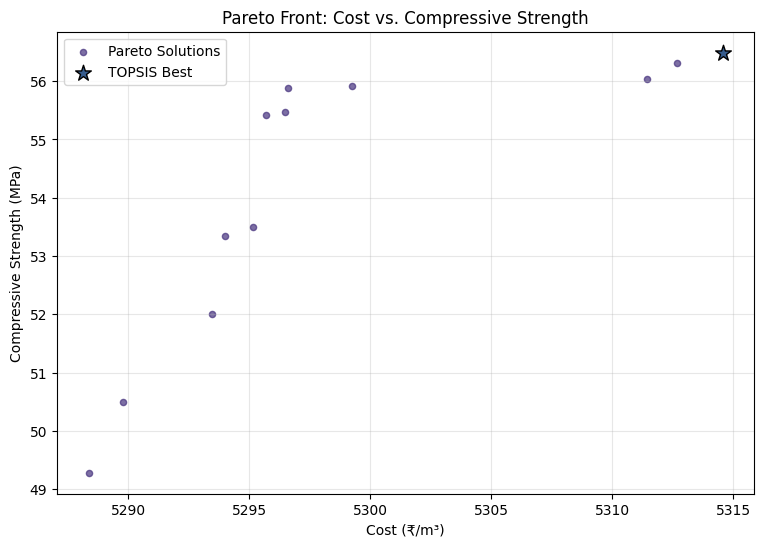


=== TOPSIS Selected Solution ===
  Cement            :   100.00 kg/m³
  Water             :   180.00 kg/m³
  Coarse aggregate  :  1183.21 kg/m³
  Fine aggregate    :   550.00 kg/m³
  FA                :   107.99 kg/m³
  SF                :     0.40 kg/m³
  GGBFS             :   151.61 kg/m³
  SP                :     0.10 kg/m³
  Cost (₹/m³)      :  5314.56
  Strength (MPa)   :    56.49
  TOPSIS Score     : 0.9471
  Constraints OK   : True

=== First 5 Pareto-Optimal Mixes ===

Mix 1:
  Cement            :   100.00 kg/m³
  Water             :   180.00 kg/m³
  Coarse aggregate  :  1183.22 kg/m³
  Fine aggregate    :   550.00 kg/m³
  FA                :   107.99 kg/m³
  SF                :     0.35 kg/m³
  GGBFS             :   151.66 kg/m³
  SP                :     0.10 kg/m³
  Cost (₹/m³)      :  5312.66
  Strength (MPa)   :    56.31
  Constraints OK   : True

Mix 2:
  Cement            :   100.00 kg/m³
  Water             :   180.03 kg/m³
  Coarse aggregate  :  1183.24 kg/m³
  Fine ag

In [ ]:
# === MOO for Concrete Mix Design (NSGA-II + TOPSIS) ===
# Assumes you already have: loaded_catboost_model (CatBoostRegressor) in memory

# loaded_catboost_model = joblib.load('best_catboost_model.pkl')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib # Import joblib for loading the model

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize

# ---------------------------
# Materials, Costs (₹/kg) & Densities (kg/m³), Bounds (kg/m³)
# ---------------------------
material_names = [
    'Cement','Water','Coarse aggregate','Fine aggregate','FA','SF','GGBFS','SP'
]

unit_costs = {
    'Cement': 9,           # ₹/kg
    'Water': 0.01,          # ₹/kg
    'Coarse aggregate': 1.5,# ₹/kg
    'Fine aggregate': 2.5,  # ₹/kg
    'FA': 3.00,              # ₹/kg
    'SF': 45.0,              # ₹/kg
    'GGBFS': 6,           # ₹/kg
    'SP': 110.0              # ₹/kg
}

densities = {
    'Cement': 3150, 'Water': 1000, 'Coarse aggregate': 2600, 'Fine aggregate': 2600,
    'FA': 2200, 'SF': 2200, 'GGBFS': 2900, 'SP': 1100
}

# Wide bounds; constraints enforce feasibility
bounds_lower = [100, 120, 800, 550, 0,   0,   0,  0]
bounds_upper = [500, 200, 1300,1100,300, 100, 500, 20]
xl = np.array(bounds_lower, dtype=float)
xu = np.array(bounds_upper, dtype=float)

# ---------------------------
# Load strength model (CatBoost)
# ---------------------------
loaded_catboost_model = None
catboost_model_path = "best_catboost_model.pkl" # Corrected filename

try:
    # Load the model using joblib
    loaded_catboost_model = joblib.load(catboost_model_path)
    print("✓ Loaded CatBoost model from:", catboost_model_path)
except FileNotFoundError:
    print(f"! CatBoost model file not found at {catboost_model_path}. Please ensure you have run the cell to save the best CatBoost model.")
except Exception as e:
    print("! Failed to load CatBoost model.\n", e)
    loaded_catboost_model = None # Ensure it's None if loading fails

# ---------------------------
# Strength prediction wrapper (uses your loaded_catboost_model)
# ---------------------------
def predict_strength(x_row: np.ndarray) -> float:
    # Expecting 'loaded_catboost_model' to exist and be loaded
    if loaded_catboost_model is not None:
        try:
            x_df = pd.DataFrame([x_row], columns=material_names)
            return float(loaded_catboost_model.predict(x_df)[0])
        except Exception as e:
            print(f"Error during prediction: {e}")
            return 0.0 # Return a low strength value on error
    else:
        # Fallback or error handling if model is not loaded
        print("! CatBoost model not loaded. Cannot predict strength.")
        return 0.0 # Return 0 strength if model is not available

# ---------------------------
# Constraints: return g array with g_i <= 0
# ---------------------------
def constraints(material_quantities):
    cement, water, coarse_agg, fine_agg, fa, sf, ggbfs, sp = material_quantities
    g = []

    cementitious = cement + fa + sf + ggbfs
    total_agg   = coarse_agg + fine_agg

    # 1–2) 0.30 <= w/cm <= 0.50
    if cementitious > 0:
        wcm = water / cementitious
        g.append(0.30 - wcm)
        g.append(wcm - 0.50)
    else:
        g += [1.0, 1.0]

    # 3–4) Fine/Total aggregate ratio: 0.30 <= FA/TA <= 0.45
    if total_agg > 0:
        fa_ta = fine_agg / total_agg
        g.append(0.30 - fa_ta)
        g.append(fa_ta - 0.45)
    else:
        g += [1.0, 1.0]

    # 5–6) Volume balance ~ 1.0 ± 0.02
    target_volume = 1.0
    volume = sum(material_quantities[i] / densities[m] for i, m in enumerate(material_names))
    tol = 0.02
    g.append(volume - (target_volume + tol))
    g.append((target_volume - tol) - volume)

    # 7) Cementitious >= 300 kg/m³
    g.append(300.0 - cementitious)

    # 8) Cement <= 450 kg/m³
    g.append(cement - 450.0)

    # 9–10) Water 120–200 kg/m³
    g.append(120.0 - water)
    g.append(water - 200.0)

    # 11) FA <= 30% of cementitious
    g.append((fa / cementitious - 0.30) if cementitious > 0 else 1.0)

    # 12) GGBFS <= 50% of cementitious
    g.append((ggbfs / cementitious - 0.50) if cementitious > 0 else 1.0)

    # 13) SF <= 10% of cementitious
    g.append((sf / cementitious - 0.10) if cementitious > 0 else 1.0)

    # 14) SP <= 2% of cementitious
    g.append((sp / cementitious - 0.02) if cementitious > 0 else 1.0)

    return np.array(g, dtype=float)

# ---------------------------
# Problem definition
# ---------------------------
class ConcreteMixProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=len(material_names),
            n_obj=2,
            n_ieq_constr=14,   # keep in sync with constraints() length
            xl=xl,
            xu=xu
        )

    def _evaluate(self, x, out, *args, **kwargs):
        # Objectives
        cost = float(sum(x[i] * unit_costs[m] for i, m in enumerate(material_names)))   # Minimize
        strength = predict_strength(x)                                                  # Maximize

        # Inequality constraints
        g = constraints(x)

        out["F"] = np.array([cost, -strength])  # Minimize cost, minimize (-strength) => maximize strength
        out["G"] = g

# ---------------------------
# Run NSGA-II
# ---------------------------
problem = ConcreteMixProblem()
algorithm = NSGA2(pop_size=300)
termination = get_termination("n_gen", 1000)  # adjust as needed

res = minimize(problem, algorithm, termination, seed=42, verbose=True)

print("\n=== Optimization finished ===")
try:
    print(f"Generations: {res.algorithm.n_gen}")
    print(f"Function evaluations: {res.algorithm.evaluator.n_eval}")
except Exception:
    pass

if res.F is None or len(res.F) == 0:
    raise RuntimeError("No feasible solutions found. Try relaxing bounds or increasing generations.")

# ---------------------------
# TOPSIS helper
# ---------------------------
def topsis_select(F, weights=None, beneficial=None):
    """
    F: (n_solutions x n_criteria) array
    weights: positive weights (default 1s)
    beneficial: boolean array; True if higher is better
    Returns: scores, best_index
    """
    F = np.asarray(F, dtype=float)
    n, m = F.shape
    if weights is None:
        weights = np.ones(m)
    if beneficial is None:
        beneficial = np.array([False] * m)

    # Normalize each criterion vector
    norm = np.linalg.norm(F, axis=0)
    norm[norm == 0] = 1.0
    R = F / norm

    # Apply weights
    W = R * weights

    # Ideal best/worst
    ideal_best = np.empty(m)
    ideal_worst = np.empty(m)
    for j in range(m):
        if beneficial[j]:
            ideal_best[j] = np.max(W[:, j])
            ideal_worst[j] = np.min(W[:, j])
        else:
            ideal_best[j] = np.min(W[:, j])
            ideal_worst[j] = np.max(W[:, j])

    # Distances
    d_pos = np.linalg.norm(W - ideal_best, axis=1)
    d_neg = np.linalg.norm(W - ideal_worst, axis=1)

    # Scores
    scores = d_neg / (d_pos + d_neg + 1e-12)
    best_idx = int(np.argmax(scores))
    return scores, best_idx

# ---------------------------
# Plot Pareto + highlight TOPSIS Best
# ---------------------------
costs = res.F[:, 0]
strengths = -res.F[:, 1]
F_criteria = np.column_stack([costs, strengths])

scores, best_idx = topsis_select(
    F_criteria,
    weights=np.array([0.6, 0.4]),        # tweak to emphasize either criterion
    beneficial=np.array([False, True])   # cost lower is better, strength higher is better
)

plt.figure(figsize=(9, 6))
plt.scatter(costs, strengths, s=20, label="Pareto Solutions", alpha=0.7)
plt.scatter(costs[best_idx], strengths[best_idx], s=140, marker="*", edgecolors="k",
            label="TOPSIS Best")
plt.title("Pareto Front: Cost vs. Compressive Strength")
plt.xlabel("Cost (₹/m³)")
plt.ylabel("Compressive Strength (MPa)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---------------------------
# Display TOPSIS-best and a few Pareto mixes
# ---------------------------
print("\n=== TOPSIS Selected Solution ===")
best_x = res.X[best_idx]
for j, m in enumerate(material_names):
    print(f"  {m:<18}: {best_x[j]:8.2f} kg/m³")
print(f"  Cost (₹/m³)      : {costs[best_idx]:8.2f}")
print(f"  Strength (MPa)   : {strengths[best_idx]:8.2f}")
print(f"  TOPSIS Score     : {scores[best_idx]:.4f}")
print(f"  Constraints OK   : {np.all(constraints(best_x) <= 1e-6)}")

print("\n=== First 5 Pareto-Optimal Mixes ===")
for i, sol in enumerate(res.X[:5]):
    print(f"\nMix {i+1}:")
    for j, m in enumerate(material_names):
        print(f"  {m:<18}: {sol[j]:8.2f} kg/m³")
    print(f"  Cost (₹/m³)      : {costs[i]:8.2f}")
    print(f"  Strength (MPa)   : {strengths[i]:8.2f}")
    ok = np.all(constraints(sol) <= 1e-6)
    print(f"  Constraints OK   : {ok}")

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
import joblib
import pandas as pd

# Load the saved models
loaded_catboost_model = joblib.load('best_catboost_model.pkl')
loaded_xgboost_model = joblib.load('best_xgboost_model.pkl')
loaded_random_forest_model = joblib.load('best_random_forest_model.pkl')
loaded_lightgbm_model = joblib.load('best_lightgbm_model.pkl')

print("All models loaded successfully.")

# Load the saved training and testing data
loaded_X_train = pd.read_csv('X_train.csv')
loaded_X_test = pd.read_csv('X_test.csv')
loaded_y_train = pd.read_csv('y_train.csv')
loaded_y_test = pd.read_csv('y_test.csv')

print("Training and testing data loaded successfully.")

ValueError: EOF: reading array data, expected 76736 bytes got 14432

In [ ]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.8 MB/s eta 0:00:00


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      1 |  0.000000E+00 |  4.4103547064 |             - |             -
     2 |      300 |      1 |  0.000000E+00 |  0.2318316252 |  0.000000E+00 |             f
     3 |      400 |      1 |  0.000000E+00 |  0.1525602814 |  0.000000E+00 |             f
     4 |      500 |      1 |  0.000000E+00 |  0.1025261203 |  2.422424E+03 |         ideal
     5 |      600 |      1 |  0.000000E+00 |  0.0701123790 |  0.000000E+00 |             f
     6 |      700 |      1 |  0.000000E+00 |  0.0475120827 |  0.000000E+00 |             f
     7 |      800 |      1 |  0.000000E+00 |  0.0293920924 |  0.000000E+00 |             f
     8 |      900 |      1 |  0.000000E+00 |  0.0167953894 |  0.000000E+00 |             f
     9 |     1000 |      2 |  0.000000E+00 |  0.0090440530 |  1.0000000000 |         ideal
    10 |     1100 |      2 |  0.000000E+00 |  0.0043060688 |  0.1264870213 |         ideal

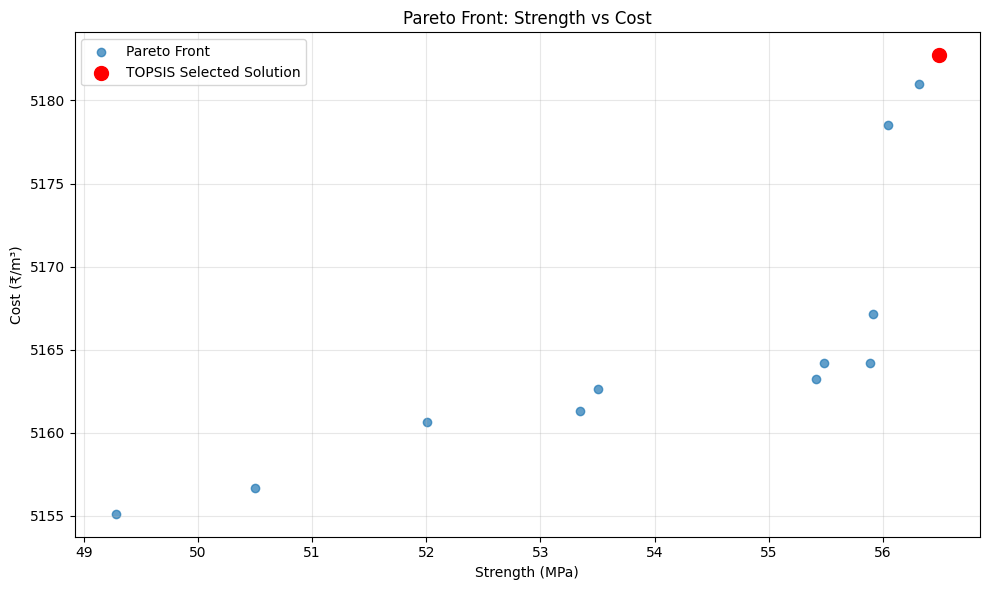


Pareto front contains 12 solutions
Strength range: 49.28 - 56.49 MPa
Cost range: 5155.13 - 5182.72 ₹/m³

Results saved to 'pareto_front_results.csv'


In [ ]:
import numpy as np
import pickle
import pandas as pd
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt

# Load your trained model
with open('best_catboost_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Material definitions
material_names = ['Cement', 'Water', 'Coarse aggregate', 'Fine aggregate', 'FA', 'SF', 'GGBFS', 'SP']

unit_costs = {
    'Cement': 9,           # ₹/kg
    'Water': 0.01,          # ₹/kg
    'Coarse aggregate': 1.5,# ₹/kg
    'Fine aggregate': 2.5,  # ₹/kg
    'FA': 3.00,             # ₹/kg
    'SF': 45.0,             # ₹/kg
    'GGBFS': 6,             # ₹/kg
    'SP': 120.0             # ₹/kg
}

densities = {
    'Cement': 3150, 'Water': 1000, 'Coarse aggregate': 2600, 'Fine aggregate': 2600,
    'FA': 2200, 'SF': 2200, 'GGBFS': 2900, 'SP': 1100
}

# Bounds
bounds_lower = [100, 120, 800, 500, 0, 0, 0, 0]
bounds_upper = [500, 200, 1300, 1100, 300, 100, 500, 20]

class ConcreteOptimizationProblem(Problem):
    def __init__(self):
        super().__init__(n_var=8,
                         n_obj=2,
                         n_constr=14,
                         xl=np.array(bounds_lower),
                         xu=np.array(bounds_upper))

    def _evaluate(self, X, out, *args, **kwargs):
        n_samples = X.shape[0]
        f1 = np.zeros(n_samples)  # Strength (to be maximized, so we'll minimize negative strength)
        f2 = np.zeros(n_samples)  # Cost

        # Calculate strength using the trained model
        X_df = pd.DataFrame(X, columns=material_names)
        strength_predictions = model.predict(X_df)
        f1 = -strength_predictions  # Negative because we want to maximize strength

        # Calculate cost
        for i in range(n_samples):
            cost = 0
            for j, material in enumerate(material_names):
                cost += X[i, j] * unit_costs[material]
            cost += X[i, 1] * unit_costs['Water'] # Explicitly add water cost
            f2[i] = cost

        # Calculate constraints
        G = np.zeros((n_samples, 14))
        for i in range(n_samples):
            material_quantities = X[i]
            cement, water, coarse_agg, fine_agg, fa, sf, ggbfs, sp = material_quantities

            cementitious = cement + fa + sf + ggbfs
            total_agg = coarse_agg + fine_agg

            # 1–2) 0.30 <= w/cm <= 0.50
            if cementitious > 0:
                wcm = water / cementitious
                G[i, 0] = 0.25 - wcm
                G[i, 1] = wcm - 0.60
            else:
                G[i, 0] = 1.0
                G[i, 1] = 1.0

            # 3–4) Fine/Total aggregate ratio: 0.30 <= FA/TA <= 0.45
            if total_agg > 0:
                fa_ta = fine_agg / total_agg
                G[i, 2] = 0.30 - fa_ta
                G[i, 3] = fa_ta - 0.45
            else:
                G[i, 2] = 1.0
                G[i, 3] = 1.0

            # 5–6) Volume balance ~ 1.0 ± 0.02
            target_volume = 1.0
            volume = sum(material_quantities[k] / densities[m] for k, m in enumerate(material_names))
            tol = 0.02
            G[i, 4] = volume - (target_volume + tol)
            G[i, 5] = (target_volume - tol) - volume

            # 7) Cementitious >= 300 kg/m³
            G[i, 6] = 300.0 - cementitious

            # 8) Cement <= 450 kg/m³
            G[i, 7] = cement - 450.0

            # 9–10) Water 120–200 kg/m³
            G[i, 8] = 120.0 - water
            G[i, 9] = water - 200.0

            # 11) FA <= 30% of cementitious
            if cementitious > 0:
                G[i, 10] = (fa / cementitious - 0.30)
            else:
                G[i, 10] = 1.0

            # 12) GGBFS <= 30% of cementitious
            if cementitious > 0:
                G[i, 11] = (ggbfs / cementitious - 0.30)
            else:
                G[i, 11] = 1.0

            # 13) SF <= 10% of cementitious
            if cementitious > 0:
                G[i, 12] = (sf / cementitious - 0.10)
            else:
                G[i, 12] = 1.0

            # 14) SP <= 2% of cementitious
            if cementitious > 0:
                G[i, 13] = (sp / cementitious - 0.02)
            else:
                G[i, 13] = 1.0

        out["F"] = np.column_stack([f1, f2])
        out["G"] = G

def topsis_selection(pareto_front, weights=[0.5, 0.5]):
    """
    TOPSIS method for selecting the best solution from Pareto front
    """
    # Normalize the objectives
    f1 = pareto_front[:, 0]  # Negative strength (minimize)
    f2 = pareto_front[:, 1]  # Cost (minimize)

    # Convert negative strength back to positive for better interpretation
    strength = -f1

    # Create decision matrix
    decision_matrix = np.column_stack([strength, f2])

    # Normalize the decision matrix
    norm_matrix = decision_matrix / np.sqrt(np.sum(decision_matrix**2, axis=0))

    # Weighted normalized decision matrix
    weighted_norm_matrix = norm_matrix * weights

    # Ideal and negative ideal solutions
    # For strength (first column), higher is better (positive ideal is max)
    # For cost (second column), lower is better (positive ideal is min)
    ideal_solution = np.array([np.max(weighted_norm_matrix[:, 0]), np.min(weighted_norm_matrix[:, 1])])
    negative_ideal_solution = np.array([np.min(weighted_norm_matrix[:, 0]),
                                       np.max(weighted_norm_matrix[:, 1])])

    # Calculate distances
    dist_to_ideal = np.sqrt(np.sum((weighted_norm_matrix - ideal_solution)**2, axis=1))
    dist_to_negative_ideal = np.sqrt(np.sum((weighted_norm_matrix - negative_ideal_solution)**2, axis=1))

    # Calculate relative closeness
    relative_closeness = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)

    # Select the best solution
    best_idx = np.argmax(relative_closeness)

    return best_idx, relative_closeness

# Setup and run optimization
problem = ConcreteOptimizationProblem()

algorithm = NSGA2(
    pop_size=200,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res = minimize(problem,
               algorithm,
               ('n_gen', 800),
               seed=42,
               verbose=True)

# Get Pareto front solutions
pareto_front = res.F
pareto_solutions = res.X

# Apply TOPSIS to select the best solution
best_idx, closeness_scores = topsis_selection(pareto_front)
best_solution = pareto_solutions[best_idx]
best_objectives = pareto_front[best_idx]

print(f"\nBest solution selected by TOPSIS:")
print(f"Index: {best_idx}")
print(f"Strength: {-best_objectives[0]:.2f} MPa")
print(f"Cost: {best_objectives[1]:.2f} ₹/m³")
print("\nMaterial quantities (kg/m³):")
for i, material in enumerate(material_names):
    print(f"{material}: {best_solution[i]:.2f}")

# Plot Pareto front
plt.figure(figsize=(10, 6))
plt.scatter(-pareto_front[:, 0], pareto_front[:, 1], alpha=0.7, label='Pareto Front')
plt.scatter(-best_objectives[0], best_objectives[1], color='red', s=100,
           label='TOPSIS Selected Solution')
plt.xlabel('Strength (MPa)')
plt.ylabel('Cost (₹/m³)')
plt.title('Pareto Front: Strength vs Cost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pareto_front.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis
print(f"\nPareto front contains {len(pareto_front)} solutions")
print(f"Strength range: {np.min(-pareto_front[:, 0]):.2f} - {np.max(-pareto_front[:, 0]):.2f} MPa")
print(f"Cost range: {np.min(pareto_front[:, 1]):.2f} - {np.max(pareto_front[:, 1]):.2f} ₹/m³")

# Save results to CSV
results_df = pd.DataFrame(pareto_solutions, columns=material_names)
results_df['Strength_MPa'] = -pareto_front[:, 0]
results_df['Cost_Rs_per_m3'] = pareto_front[:, 1]
results_df['TOPSIS_Score'] = closeness_scores
results_df.to_csv('pareto_front_results.csv', index=False)
print("\nResults saved to 'pareto_front_results.csv'")

Running NSGA-II optimization...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      300 |      1 |  0.000000E+00 |  3.7996755454 |             - |             -
     2 |      500 |      1 |  0.000000E+00 |  0.1781768810 |  1.891723E+03 |         ideal
     3 |      700 |      1 |  0.000000E+00 |  0.1020450449 |  0.000000E+00 |             f
     4 |      900 |      1 |  0.000000E+00 |  0.0605442479 |  0.000000E+00 |             f
     5 |     1100 |      1 |  0.000000E+00 |  0.0325679978 |  0.000000E+00 |             f
     6 |     1300 |      1 |  0.000000E+00 |  0.0156469715 |  0.000000E+00 |             f
     7 |     1500 |      2 |  0.000000E+00 |  0.0070914862 |  1.0000000000 |         ideal
     8 |     1700 |      4 |  0.000000E+00 |  0.0031544769 |  0.0249197778 |         ideal
     9 |     1900 |      4 |  0.000000E+00 |  0.0009340861 |  0.0054774554 |         ideal
    10 |     2100 |      5 |  0.000000E+00 |  0.0000469230

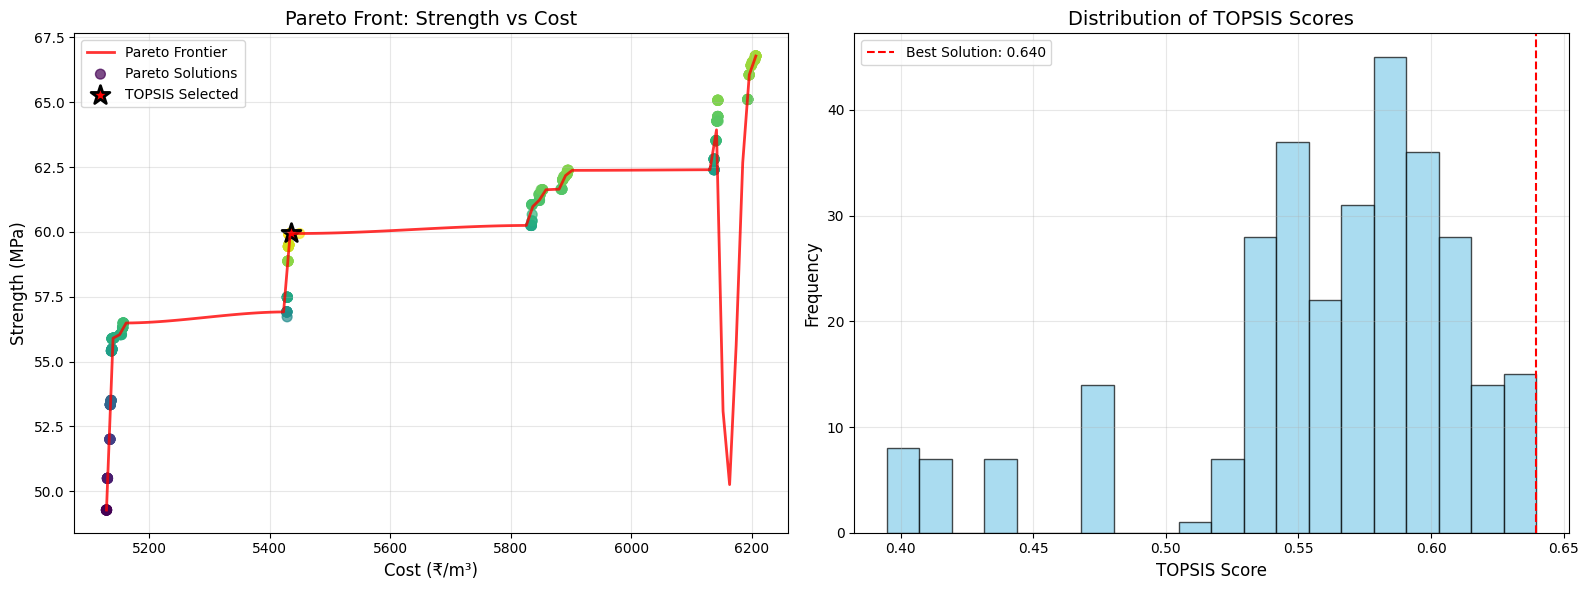


Pareto front analysis:
Number of solutions: 300
Strength range: 49.28 - 66.78 MPa
Cost range: 5128.83 - 6207.07 ₹/m³
Solution diversity: 212.3438

Detailed results saved to 'detailed_pareto_results.csv'


In [ ]:
import numpy as np
import pickle
import pandas as pd
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.lhs import LHS
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

# Set style for better plots
plt.style.use('default')
sns.set_palette("viridis")

# Load your trained model
with open('best_catboost_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Material definitions
material_names = ['Cement', 'Water', 'Coarse aggregate', 'Fine aggregate', 'FA', 'SF', 'GGBFS', 'SP']

unit_costs = {
    'Cement': 9,           # ₹/kg
    'Water': 0.01,         # ₹/kg
    'Coarse aggregate': 1.5,# ₹/kg
    'Fine aggregate': 2.5,  # ₹/kg
    'FA': 3.00,             # ₹/kg
    'SF': 45.0,             # ₹/kg
    'GGBFS': 6,             # ₹/kg
    'SP': 120.0             # ₹/kg
}

densities = {
    'Cement': 3150, 'Water': 1000, 'Coarse aggregate': 2600, 'Fine aggregate': 2600,
    'FA': 2200, 'SF': 2200, 'GGBFS': 2900, 'SP': 1100
}

# Bounds
bounds_lower = [100, 120, 800, 500, 0, 0, 0, 0]
bounds_upper = [500, 200, 1300, 1100, 300, 100, 500, 20]

class ConcreteOptimizationProblem(Problem):
    def __init__(self):
        super().__init__(n_var=8,
                         n_obj=2,
                         n_constr=14,
                         xl=np.array(bounds_lower),
                         xu=np.array(bounds_upper))

    def _evaluate(self, X, out, *args, **kwargs):
        n_samples = X.shape[0]
        f1 = np.zeros(n_samples)  # Strength (to be maximized, so we'll minimize negative strength)
        f2 = np.zeros(n_samples)  # Cost

        # Calculate strength using the trained model
        X_df = pd.DataFrame(X, columns=material_names)
        strength_predictions = model.predict(X_df)
        f1 = -strength_predictions  # Negative because we want to maximize strength

        # Calculate cost
        for i in range(n_samples):
            cost = 0
            for j, material in enumerate(material_names):
                cost += X[i, j] * unit_costs[material]
            f2[i] = cost

        # Calculate constraints
        G = np.zeros((n_samples, 14))
        for i in range(n_samples):
            material_quantities = X[i]
            cement, water, coarse_agg, fine_agg, fa, sf, ggbfs, sp = material_quantities

            cementitious = cement + fa + sf + ggbfs
            total_agg = coarse_agg + fine_agg

            # 1–2) 0.30 <= w/cm <= 0.50
            if cementitious > 0:
                wcm = water / cementitious
                G[i, 0] = 0.25 - wcm
                G[i, 1] = wcm - 0.60
            else:
                G[i, 0] = 1.0
                G[i, 1] = 1.0

            # 3–4) Fine/Total aggregate ratio: 0.30 <= FA/TA <= 0.45
            if total_agg > 0:
                fa_ta = fine_agg / total_agg
                G[i, 2] = 0.30 - fa_ta
                G[i, 3] = fa_ta - 0.45
            else:
                G[i, 2] = 1.0
                G[i, 3] = 1.0

            # 5–6) Volume balance ~ 1.0 ± 0.02
            target_volume = 1.0
            volume = sum(material_quantities[k] / densities[m] for k, m in enumerate(material_names))
            tol = 0.02
            G[i, 4] = volume - (target_volume + tol)
            G[i, 5] = (target_volume - tol) - volume

            # 7) Cementitious >= 300 kg/m³
            G[i, 6] = 300.0 - cementitious

            # 8) Cement <= 450 kg/m³
            G[i, 7] = cement - 450.0

            # 9–10) Water 120–200 kg/m³
            G[i, 8] = 120.0 - water
            G[i, 9] = water - 200.0

            # 11) FA <= 30% of cementitious
            if cementitious > 0:
                G[i, 10] = (fa / cementitious - 0.30)
            else:
                G[i, 10] = 1.0

            # 12) GGBFS <= 30% of cementitious
            if cementitious > 0:
                G[i, 11] = (ggbfs / cementitious - 0.30)
            else:
                G[i, 11] = 1.0

            # 13) SF <= 10% of cementitious
            if cementitious > 0:
                G[i, 12] = (sf / cementitious - 0.10)
            else:
                G[i, 12] = 1.0

            # 14) SP <= 2% of cementitious
            if cementitious > 0:
                G[i, 13] = (sp / cementitious - 0.02)
            else:
                G[i, 13] = 1.0

        out["F"] = np.column_stack([f1, f2])
        out["G"] = G

def topsis_selection(pareto_front, weights=[0.5, 0.5]):
    """
    TOPSIS method for selecting the best solution from Pareto front
    """
    if len(pareto_front) < 2:
        return 0, np.ones(len(pareto_front))

    # Normalize the objectives
    f1 = pareto_front[:, 0]  # Negative strength (minimize)
    f2 = pareto_front[:, 1]  # Cost (minimize)

    # Convert negative strength back to positive for better interpretation
    strength = -f1

    # Create decision matrix
    decision_matrix = np.column_stack([strength, f2])

    # Normalize the decision matrix
    with np.errstate(divide='ignore', invalid='ignore'):
        norm_matrix = decision_matrix / np.sqrt(np.sum(decision_matrix**2, axis=0))
        norm_matrix = np.nan_to_num(norm_matrix, nan=0.0, posinf=0.0, neginf=0.0)

    # Weighted normalized decision matrix
    weighted_norm_matrix = norm_matrix * np.array(weights)

    # Ideal and negative ideal solutions
    ideal_solution = np.array([np.max(weighted_norm_matrix[:, 0]), np.min(weighted_norm_matrix[:, 1])])
    negative_ideal_solution = np.array([np.min(weighted_norm_matrix[:, 0]),
                                       np.max(weighted_norm_matrix[:, 1])])

    # Calculate distances
    dist_to_ideal = np.sqrt(np.sum((weighted_norm_matrix - ideal_solution)**2, axis=1))
    dist_to_negative_ideal = np.sqrt(np.sum((weighted_norm_matrix - negative_ideal_solution)**2, axis=1))

    # Calculate relative closeness
    with np.errstate(divide='ignore', invalid='ignore'):
        relative_closeness = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)
        relative_closeness = np.nan_to_num(relative_closeness, nan=0.0, posinf=0.0, neginf=0.0)

    # Select the best solution
    best_idx = np.argmax(relative_closeness)

    return best_idx, relative_closeness

def refine_pareto_front(problem, initial_solutions, n_generations=100):
    """Refine the Pareto front with additional generations"""
    algorithm = NSGA2(
        pop_size=len(initial_solutions),
        n_offsprings=len(initial_solutions),
        sampling=initial_solutions,
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )

    res_refined = minimize(problem,
                          algorithm,
                          ('n_gen', n_generations),
                          seed=42,
                          verbose=False)

    return res_refined

# Setup and run optimization with larger population and more generations
problem = ConcreteOptimizationProblem()

# Use Latin Hypercube Sampling for better initial population
sampling = LHS()

algorithm = NSGA2(
    pop_size=300,  # Increased population size
    n_offsprings=200,
    sampling=sampling,
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

print("Running NSGA-II optimization...")
res = minimize(problem,
               algorithm,
               ('n_gen', 1000),  # Increased generations
               seed=42,
               verbose=True)

# Get all solutions
all_solutions = res.pop.get("X")
all_objectives = res.pop.get("F")
all_constraints = res.pop.get("G")

# Filter feasible solutions
feasible_mask = np.all(all_constraints <= 0, axis=1)
feasible_solutions = all_solutions[feasible_mask]
feasible_objectives = all_objectives[feasible_mask]

print(f"Found {len(feasible_solutions)} feasible solutions")

if len(feasible_solutions) > 0:
    # Get non-dominated solutions
    nds = NonDominatedSorting().do(feasible_objectives) # Removed only_non_dominated=True
    # Flatten the list of lists returned by NonDominatedSorting().do()
    flat_nds = [item for sublist in nds for item in sublist]

    pareto_solutions = feasible_solutions[flat_nds]
    pareto_front = feasible_objectives[flat_nds]

    print(f"Pareto front contains {len(pareto_front)} solutions")

    # Refine the Pareto front
    if len(pareto_solutions) > 10:
        print("Refining Pareto front...")
        res_refined = refine_pareto_front(problem, pareto_solutions, n_generations=200)
        pareto_solutions = res_refined.pop.get("X")
        pareto_front = res_refined.pop.get("F")

        # Filter non-dominated again
        nds = NonDominatedSorting().do(pareto_front) # Removed only_non_dominated=True
        # Flatten the list of lists returned by NonDominatedSorting().do()
        flat_nds = [item for sublist in nds for item in sublist]
        pareto_front = pareto_front[flat_nds]
        pareto_solutions = pareto_solutions[flat_nds]
        print(f"Refined Pareto front contains {len(pareto_front)} solutions")

    # Apply TOPSIS to select the best solution
    best_idx, closeness_scores = topsis_selection(pareto_front)
    best_solution = pareto_solutions[best_idx]
    best_objectives = pareto_front[best_idx]

    print(f"\nBest solution selected by TOPSIS:")
    print(f"Strength: {-best_objectives[0]:.2f} MPa")
    print(f"Cost: {best_objectives[1]:.2f} ₹/m³")
    print("\nMaterial quantities (kg/m³):")
    for i, material in enumerate(material_names):
        print(f"{material}: {best_solution[i]:.2f}")

    # Enhanced visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Pareto front with smooth representation
    strengths = -pareto_front[:, 0]
    costs = pareto_front[:, 1]

    # Sort for better plotting
    sort_idx = np.argsort(costs)
    strengths = strengths[sort_idx]
    costs = costs[sort_idx]

    # Create smooth curve using interpolation
    if len(costs) > 3:
        x_smooth = np.linspace(costs.min(), costs.max(), 100)
        y_smooth = griddata(costs, strengths, x_smooth, method='cubic')
        ax1.plot(x_smooth, y_smooth, 'r-', alpha=0.8, linewidth=2, label='Pareto Frontier')

    ax1.scatter(costs, strengths, alpha=0.7, s=50, c=closeness_scores[sort_idx],
               cmap='viridis', label='Pareto Solutions')
    ax1.scatter(best_objectives[1], -best_objectives[0], color='red', s=200,
               marker='*', label='TOPSIS Selected', edgecolors='black', linewidth=2)

    ax1.set_xlabel('Cost (₹/m³)', fontsize=12)
    ax1.set_ylabel('Strength (MPa)', fontsize=12)
    ax1.set_title('Pareto Front: Strength vs Cost', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: TOPSIS scores distribution
    if len(closeness_scores) > 1:
        ax2.hist(closeness_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.axvline(closeness_scores[best_idx], color='red', linestyle='--',
                   label=f'Best Solution: {closeness_scores[best_idx]:.3f}')
        ax2.set_xlabel('TOPSIS Score', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.set_title('Distribution of TOPSIS Scores', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('enhanced_pareto_front.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Additional analysis
    print(f"\nPareto front analysis:")
    print(f"Number of solutions: {len(pareto_front)}")
    print(f"Strength range: {np.min(-pareto_front[:, 0]):.2f} - {np.max(-pareto_front[:, 0]):.2f} MPa")
    print(f"Cost range: {np.min(pareto_front[:, 1]):.2f} - {np.max(pareto_front[:, 1]):.2f} ₹/m³")

    # Calculate diversity metric
    if len(pareto_front) > 1:
        diversity = np.mean(np.std(pareto_front, axis=0))
        print(f"Solution diversity: {diversity:.4f}")

    # Save results to CSV
    results_df = pd.DataFrame(pareto_solutions, columns=material_names)
    results_df['Strength_MPa'] = -pareto_front[:, 0]
    results_df['Cost_Rs_per_m3'] = pareto_front[:, 1]
    results_df['TOPSIS_Score'] = closeness_scores

    # Add constraint information
    def calculate_constraints(x):
        """Helper function to calculate constraint violations for a single solution"""
        cement, water, coarse_agg, fine_agg, fa, sf, ggbfs, sp = x

        cementitious = cement + fa + sf + ggbfs
        total_agg = coarse_agg + fine_agg

        constraints_list = []

        # Water-cement ratio constraints
        if cementitious > 0:
            wcm = water / cementitious
            constraints_list.extend([0.25 - wcm, wcm - 0.60]) # Use adjusted constraints
        else:
             constraints_list.extend([1.0, 1.0])

        # Aggregate ratio constraints
        if total_agg > 0:
            fa_ta = fine_agg / total_agg
            constraints_list.extend([0.30 - fa_ta, fa_ta - 0.45])
        else:
            constraints_list.extend([1.0, 1.0])

        # Volume constraints
        volume = sum(x[i] / densities[m] for i, m in enumerate(material_names))
        constraints_list.extend([volume - 1.02, 0.98 - volume]) # Use adjusted tolerance

        # Other constraints
        constraints_list.extend([
            300.0 - cementitious,
            cement - 450.0,
            120.0 - water,
            water - 200.0
        ])

        # Supplementary material constraints
        if cementitious > 0:
            constraints_list.extend([
                fa / cementitious - 0.30,
                ggbfs / cementitious - 0.30,
                sf / cementitious - 0.10,
                sp / cementitious - 0.02
            ])
        else:
             constraints_list.extend([1.0, 1.0, 1.0, 1.0])


        return np.array(constraints_list)

    results_df['Feasibility_Score'] = results_df.apply(lambda row: np.sum(calculate_constraints(row[material_names].values) <= 1e-6) / 14.0, axis=1)


    results_df.to_csv('detailed_pareto_results.csv', index=False)
    print("\nDetailed results saved to 'detailed_pareto_results.csv'")

else:
    print("No feasible solutions found. Consider relaxing constraints.")

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.1 MB/s eta 0:00:00


In [ ]:
!pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Assuming X_train, y_train, X_test, and y_test are already defined DataFrames or Series
# If they are numpy arrays, convert them to pandas objects first
# For example:
# X_train_df = pd.DataFrame(X_train, columns=[...]) # Replace with your actual column names
# y_train_series = pd.Series(y_train, name='target') # Replace 'target' with your target column name

# Save to CSV
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Training and testing data saved to CSV files.")

NameError: name 'X_train' is not defined

In [ ]:
import numpy as np
import pickle
import pandas as pd
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.visualization.scatter import Scatter
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import matplotlib.pyplot as plt

# Load your trained model
with open('best_catboost_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Material definitions
material_names = ['Cement', 'Water', 'Coarse aggregate', 'Fine aggregate', 'FA', 'SF', 'GGBFS', 'SP']

unit_costs = {
    'Cement': 10,           # ₹/kg
    'Water': 0.01,          # ₹/kg
    'Coarse aggregate': 1.5,# ₹/kg
    'Fine aggregate': 2.5,  # ₹/kg
    'FA': 3.00,             # ₹/kg
    'SF': 45.0,             # ₹/kg
    'GGBFS': 6,             # ₹/kg
    'SP': 120.0             # ₹/kg
}

densities = {
    'Cement': 3150, 'Water': 1000, 'Coarse aggregate': 2600, 'Fine aggregate': 2600,
    'FA': 2200, 'SF': 2200, 'GGBFS': 2900, 'SP': 1100
}

# Bounds
bounds_lower = [100, 120, 800, 500, 0, 0, 0, 0]
bounds_upper = [500, 200, 1300, 1100, 300, 100, 500, 20]

class ConcreteOptimizationProblem(Problem):
    def __init__(self):
        super().__init__(n_var=8,
                         n_obj=2,
                         n_constr=14,
                         xl=np.array(bounds_lower),
                         xu=np.array(bounds_upper))

    def _evaluate(self, X, out, *args, **kwargs):
        n_samples = X.shape[0]
        f1 = np.zeros(n_samples)  # Strength (to be maximized, so we'll minimize negative strength)
        f2 = np.zeros(n_samples)  # Cost

        # Calculate strength using the trained model
        X_df = pd.DataFrame(X, columns=material_names)
        strength_predictions = model.predict(X_df)
        f1 = -strength_predictions  # Negative because we want to maximize strength

        # Calculate cost
        for i in range(n_samples):
            cost = 0
            for j, material in enumerate(material_names):
                cost += X[i, j] * unit_costs[material]
            f2[i] = cost

        # Calculate constraints
        G = np.zeros((n_samples, 14))
        for i in range(n_samples):
            material_quantities = X[i]
            cement, water, coarse_agg, fine_agg, fa, sf, ggbfs, sp = material_quantities

            cementitious = cement + fa + sf + ggbfs
            total_agg = coarse_agg + fine_agg

            # 1–2) 0.30 <= w/cm <= 0.50
            if cementitious > 0:
                wcm = water / cementitious
                G[i, 0] = 0.30 - wcm
                G[i, 1] = wcm - 0.50
            else:
                G[i, 0] = 1.0
                G[i, 1] = 1.0

            # 3–4) Fine/Total aggregate ratio: 0.30 <= FA/TA <= 0.45
            if total_agg > 0:
                fa_ta = fine_agg / total_agg
                G[i, 2] = 0.30 - fa_ta
                G[i, 3] = fa_ta - 0.45
            else:
                G[i, 2] = 1.0
                G[i, 3] = 1.0

            # 5–6) Volume balance ~ 1.0 ± 0.01
            target_volume = 1.0
            volume = sum(material_quantities[k] / densities[m] for k, m in enumerate(material_names))
            tol = 0.01
            G[i, 4] = volume - (target_volume + tol)
            G[i, 5] = (target_volume - tol) - volume

            # 7) Cementitious >= 300 kg/m³
            G[i, 6] = 300.0 - cementitious

            # 8) Cement <= 450 kg/m³
            G[i, 7] = cement - 450.0

            # 9–10) Water 120–200 kg/m³
            G[i, 8] = 120.0 - water
            G[i, 9] = water - 200.0

            # 11) FA <= 30% of cementitious
            if cementitious > 0:
                G[i, 10] = (fa / cementitious - 0.30)
            else:
                G[i, 10] = 1.0

            # 12) GGBFS <= 30% of cementitious
            if cementitious > 0:
                G[i, 11] = (ggbfs / cementitious - 0.30)
            else:
                G[i, 11] = 1.0

            # 13) SF <= 10% of cementitious
            if cementitious > 0:
                G[i, 12] = (sf / cementitious - 0.10)
            else:
                G[i, 12] = 1.0

            # 14) SP <= 2% of cementitious
            if cementitious > 0:
                G[i, 13] = (sp / cementitious - 0.02)
            else:
                G[i, 13] = 1.0

        out["F"] = np.column_stack([f1, f2])
        out["G"] = G

def topsis_selection(pareto_front, weights=[0.5, 0.5]):
    """
    TOPSIS method for selecting the best solution from Pareto front
    """
    # Normalize the objectives
    f1 = pareto_front[:, 0]  # Negative strength (minimize)
    f2 = pareto_front[:, 1]  # Cost (minimize)

    # Convert negative strength back to positive for better interpretation
    strength = -f1

    # Create decision matrix
    decision_matrix = np.column_stack([strength, f2])

    # Normalize the decision matrix
    norm_matrix = decision_matrix / np.sqrt(np.sum(decision_matrix**2, axis=0))

    # Weighted normalized decision matrix
    weighted_norm_matrix = norm_matrix * weights

    # Ideal and negative ideal solutions
    ideal_best = np.max(weighted_norm_matrix[:, 0])  # Maximize strength
    ideal_worst = np.min(weighted_norm_matrix[:, 1])  # Minimize cost

    ideal_solution = np.array([ideal_best, ideal_worst])
    negative_ideal_solution = np.array([np.min(weighted_norm_matrix[:, 0]),
                                       np.max(weighted_norm_matrix[:, 1])])

    # Calculate distances
    dist_to_ideal = np.sqrt(np.sum((weighted_norm_matrix - ideal_solution)**2, axis=1))
    dist_to_negative_ideal = np.sqrt(np.sum((weighted_norm_matrix - negative_ideal_solution)**2, axis=1))

    # Calculate relative closeness
    relative_closeness = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)

    # Select the best solution
    best_idx = np.argmax(relative_closeness)

    return best_idx, relative_closeness

def refine_pareto_front(problem, initial_population, n_refinement_generations=50):
    """
    Refine the Pareto front by running additional generations
    """
    # Create a new algorithm with the initial population
    algorithm = NSGA2(
        pop_size=len(initial_population),
        n_offsprings=len(initial_population),
        sampling=initial_population,
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(eta=20),
        eliminate_duplicates=True
    )

    # Run refinement
    res_refined = minimize(problem,
                          algorithm,
                          ('n_gen', n_refinement_generations),
                          seed=42,
                          verbose=False)

    return res_refined

# Setup and run optimization with larger population and more generations
problem = ConcreteOptimizationProblem()

# First run with larger population
algorithm = NSGA2(
    pop_size=200,  # Increased population size
    n_offsprings=200,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

print("Running initial optimization with larger population...")
res = minimize(problem,
               algorithm,
               ('n_gen', 300),  # Increased generations
               seed=42,
               verbose=True)

# Get initial Pareto front
pareto_front = res.F
pareto_solutions = res.X

# Refine the Pareto front
print("Refining Pareto front...")
res_refined = refine_pareto_front(problem, pareto_solutions, n_refinement_generations=100)

# Get refined Pareto front
pareto_front = res_refined.F
pareto_solutions = res_refined.X

# Filter only non-dominated solutions
nds = NonDominatedSorting().do(pareto_front)
pareto_front = pareto_front[nds]
pareto_solutions = pareto_solutions[nds]

# Apply TOPSIS to select the best solution
best_idx, closeness_scores = topsis_selection(pareto_front)
best_solution = pareto_solutions[best_idx]
best_objectives = pareto_front[best_idx]

print(f"\nBest solution selected by TOPSIS:")
print(f"Index: {best_idx}")
print(f"Strength: {-best_objectives[0]:.2f} MPa")
print(f"Cost: {best_objectives[1]:.2f} ₹/m³")
print("\nMaterial quantities (kg/m³):")
for i, material in enumerate(material_names):
    print(f"{material}: {best_solution[i]:.2f}")

# Calculate constraint values for the best solution
cement, water, coarse_agg, fine_agg, fa, sf, ggbfs, sp = best_solution
cementitious = cement + fa + sf + ggbfs
total_agg = coarse_agg + fine_agg

print(f"\nConstraint values for best solution:")
print(f"w/cm ratio: {water/cementitious:.3f} (should be 0.30-0.50)")
print(f"Fine/total aggregate: {fine_agg/total_agg:.3f} (should be 0.30-0.45)")
volume = sum(best_solution[i] / densities[m] for i, m in enumerate(material_names))
print(f"Volume: {volume:.3f} m³ (should be 1.0 ± 0.01)")
print(f"Cementitious content: {cementitious:.1f} kg/m³ (should be >= 300)")
print(f"Cement content: {cement:.1f} kg/m³ (should be <= 450)")
print(f"Water content: {water:.1f} kg/m³ (should be 120-200)")
print(f"FA content: {fa/cementitious*100:.1f}% of cementitious (should be <= 30%)")
print(f"GGBFS content: {ggbfs/cementitious*100:.1f}% of cementitious (should be <= 30%)")
print(f"SF content: {sf/cementitious*100:.1f}% of cementitious (should be <= 10%)")
print(f"SP content: {sp/cementitious*100:.1f}% of cementitious (should be <= 2%)")

# Plot Pareto front
plt.figure(figsize=(12, 8))
plt.scatter(-pareto_front[:, 0], pareto_front[:, 1], alpha=0.7, label='Pareto Front')
plt.scatter(-best_objectives[0], best_objectives[1], color='red', s=100,
           label='TOPSIS Selected Solution')
plt.xlabel('Strength (MPa)', fontsize=12)
plt.ylabel('Cost (₹/m³)', fontsize=12)
plt.title('Pareto Front: Strength vs Cost', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pareto_front_refined.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional analysis
print(f"\nPareto front contains {len(pareto_front)} solutions")
print(f"Strength range: {np.min(-pareto_front[:, 0]):.2f} - {np.max(-pareto_front[:, 0]):.2f} MPa")
print(f"Cost range: {np.min(pareto_front[:, 1]):.2f} - {np.max(pareto_front[:, 1]):.2f} ₹/m³")

# Save results to CSV
results_df = pd.DataFrame(pareto_solutions, columns=material_names)
results_df['Strength_MPa'] = -pareto_front[:, 0]
results_df['Cost_Rs_per_m3'] = pareto_front[:, 1]
results_df['TOPSIS_Score'] = closeness_scores
results_df.to_csv('pareto_front_results_refined.csv', index=False)
print("\nResults saved to 'pareto_front_results_refined.csv'")

# Plot the distribution of solutions
plt.figure(figsize=(15, 10))
for i, material in enumerate(material_names):
    plt.subplot(3, 3, i+1)
    plt.hist(pareto_solutions[:, i], bins=20, alpha=0.7)
    plt.axvline(best_solution[i], color='red', linestyle='--', label='Best Solution')
    plt.xlabel(f'{material} (kg/m³)')
    plt.ylabel('Frequency')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.savefig('material_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

Running initial optimization with larger population...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      1 |  0.0041070165 |  4.4583390444 |             - |             -
     2 |      400 |      1 |  0.0041070165 |  0.2036455969 |             - |             -
     3 |      600 |      1 |  0.0028311876 |  0.1125279823 |             - |             -
     4 |      800 |      1 |  0.000000E+00 |  0.0662061049 |             - |             -
     5 |     1000 |      1 |  0.000000E+00 |  0.0361159999 |  2.048881E+03 |         ideal
     6 |     1200 |      1 |  0.000000E+00 |  0.0198028111 |  0.000000E+00 |             f
     7 |     1400 |      1 |  0.000000E+00 |  0.0093875504 |  4.453433E+02 |         ideal
     8 |     1600 |      1 |  0.000000E+00 |  0.0027322574 |  4.708831E+01 |         ideal
     9 |     1800 |      1 |  0.000000E+00 |  0.0005263284 |  2.524673E+01 |         ideal
    10 |     2000 |      1 |  0.000

ValueError: operands could not be broadcast together with shapes (1,4) (2,) 

In [ ]:
import pandas as pd

# Load the training and testing data from the CSV files
try:
    X_train = pd.read_csv('X_train.csv')
    y_train = pd.read_csv('y_train.csv').squeeze() # Assuming y_train is a single column
    X_test = pd.read_csv('X_test.csv')
    y_test = pd.read_csv('y_test.csv').squeeze() # Assuming y_test is a single column

    print("Training and testing data loaded successfully from CSV files.")
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)

except FileNotFoundError:
    print("Error: One or more of the CSV files were not found.")
    print("Please ensure 'X_train.csv', 'y_train.csv', 'X_test.csv', and 'y_test.csv' are in the correct directory.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Training and testing data loaded successfully from CSV files.
X_train shape: (1024, 8)
y_train shape: (1024,)
X_test shape: (257, 8)
y_test shape: (257,)
